# Paper Metrics & Plots from Saved Predictions (.npz)

This notebook generates common scientific metrics and figures from exported prediction files produced by your evaluation pipeline.

**Inputs (expected in `eval_dir`)**:
- `internal_preds_ensemble.npz` or `internal_preds_fold_*.npz`
- `external_preds_ensemble.npz` or `external_preds_fold_*.npz`

Each `.npz` should contain:
- `y_true` (0/1)
- `y_prob` (probability of class 1 = **lung**)

**Outputs (written to `out_dir`)**:
- Confusion matrix PNG
- ROC curve PNG
- PR curve PNG
- Calibration curve PNG
- `*_paper_metrics.json`
- `*_predictions.csv` with `lung/non_lung` labels
- `*_curves.npz` with curve points


In [1]:
import json
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import sys

# Class name mapping (0/1 -> string labels)
CLASS_NAMES = {0: "non_lung", 1: "lung"}


In [22]:
LIGHT_BLUE = "#87CBFF"
DARK_BLUE = "#008FFDFF"

## Runs

In [2]:
path_to_evals_patient_level = Path("/Users/LennartPhilipp/Desktop/Uni/Prowiss/Training/Evaluations/eval_internal_external_patient_level_23_02_26")

runs = [f for f in path_to_evals_patient_level.iterdir() if f.is_dir() and f.name.startswith("lung_vs_nolung")]
runs_dict = {
    r.name.removeprefix("lung_vs_nolung_2cls_"): r
    for r in runs
}

print("Found runs:")
runs_dict

Found runs:


{'t1c_fine_resnet152_22_02_2026': PosixPath('/Users/LennartPhilipp/Desktop/Uni/Prowiss/Training/Evaluations/eval_internal_external_patient_level_23_02_26/lung_vs_nolung_2cls_t1c_fine_resnet152_22_02_2026'),
 't1c_scratch_resnet34_22_02_2026': PosixPath('/Users/LennartPhilipp/Desktop/Uni/Prowiss/Training/Evaluations/eval_internal_external_patient_level_23_02_26/lung_vs_nolung_2cls_t1c_scratch_resnet34_22_02_2026'),
 't1c_scratch_inceptionv3_22_02_2026': PosixPath('/Users/LennartPhilipp/Desktop/Uni/Prowiss/Training/Evaluations/eval_internal_external_patient_level_23_02_26/lung_vs_nolung_2cls_t1c_scratch_inceptionv3_22_02_2026'),
 'maxinfo_scratch_resnext101_23_02_2026': PosixPath('/Users/LennartPhilipp/Desktop/Uni/Prowiss/Training/Evaluations/eval_internal_external_patient_level_23_02_26/lung_vs_nolung_2cls_maxinfo_scratch_resnext101_23_02_2026'),
 't1c_rough_resnext50_22_02_2026': PosixPath('/Users/LennartPhilipp/Desktop/Uni/Prowiss/Training/Evaluations/eval_internal_external_patient_le

In [3]:
OUT_ROOT = Path("/Users/LennartPhilipp/Desktop/Uni/Prowiss/Training/Metrics")

use = "ensemble"
threshold = 0.5

In [4]:
import re
import json
from pathlib import Path
import pandas as pd
import numpy as np

# Where the evaluation run folders live (your existing path)
path_to_evals_patient_level = Path("/Users/LennartPhilipp/Desktop/Uni/Prowiss/Training/Evaluations/eval_internal_external_patient_level_23_02_26")

runs = [f for f in path_to_evals_patient_level.iterdir() if f.is_dir() and f.name.startswith("lung_vs_nolung")]
runs_dict = {r.name.removeprefix("lung_vs_nolung_2cls_"): r for r in runs}

def parse_strategy(run: str):
    r = run.lower()
    # robust: look for whole tokens to avoid accidental matches
    # your runs contain "..._scratch_..." / "..._rough_..." / "..._fine_..."
    if re.search(r"(^|_)scratch(_|$)", r):
        return "scratch"
    if re.search(r"(^|_)rough(_|$)", r):
        return "rough"
    if re.search(r"(^|_)fine(_|$)", r):
        return "fine"
    return None

def apply_label_map(labels, label_map=None):
    """
    label_map example:
      {"t1c": "T1CE", "4 seq": "4 sequences", "clinical": "+clinical", "max_info": "max input"}
      {"scratch": "Scratch", "rough": "Rough pretraining", "fine": "Fine pretraining"}
    """
    if label_map is None:
        return [str(x) for x in labels]
    return [label_map.get(str(x), str(x)) for x in labels]

def parse_arch(run: str):
    r = run.lower()
    if "resnext101" in r:
        return "ResNeXt101"
    if "resnext50" in r:
        return "ResNeXt50"
    if "resnet152" in r:
        return "ResNet152"
    return None

def parse_input_variant(run: str):
    r = run.lower()

    if r.startswith("4seq"):
        return "4 seq"
    if r.startswith("t1c_clin"):
        return "clinical"
    if r.startswith("maxinfo"):
        return "max_info"
    if r.startswith("t1c"):
        return "t1c"

    return None

def format_auc_ci(val, lo, hi, decimals=3):
    if pd.isna(val):
        return ""
    if pd.isna(lo) or pd.isna(hi):
        return f"{val:.{decimals}f}"
    return f"{val:.{decimals}f} [{lo:.{decimals}f}, {hi:.{decimals}f}]"

# metrics you want to plot (these exist in your JSON example)
metrics = ["auc", "accuracy", "f1", "sensitivity", "specificity", "mcc"]

rows = []

for run, run_path in runs_dict.items():
    arch = parse_arch(run)
    if arch not in ["ResNeXt50", "ResNeXt101", "ResNet152"]:
        continue

    variant = parse_input_variant(run)
    if variant is None:
        continue

    for split in ["internal", "external"]:
        json_path = run_path / f"{split}_ensemble.json"
        if not json_path.exists():
            continue

        met = json.loads(json_path.read_text())

        rows.append({
            "run": run,
            "arch": arch,
            "variant": variant,
            "split": split,
            "auc": met.get("auc"),
            "auc_ci_low": met.get("auc_ci_low"),
            "auc_ci_high": met.get("auc_ci_high"),
        })

df_ci = pd.DataFrame(rows)

df_ci = df_ci.copy()
df_ci["strategy"] = df_ci["run"].apply(parse_strategy)

# quick check
df_ci[["run","arch","variant","strategy","split","auc"]].head(10)

df_ci.head()

,run,arch,variant,split,auc,auc_ci_low,auc_ci_high,strategy
0,t1c_fine_resnet152_22_02_2026,ResNet152,t1c,internal,0.439423,0.280134,0.618100,fine
1,t1c_fine_resnet152_22_02_2026,ResNet152,t1c,external,0.510266,0.418442,0.597810,fine
2,maxinfo_scratch_resnext101_23_02_2026,ResNeXt101,max_info,internal,0.636538,0.455207,0.805772,scratch
3,maxinfo_scratch_resnext101_23_02_2026,ResNeXt101,max_info,external,0.531124,0.445189,0.614525,scratch
4,t1c_rough_resnext50_22_02_2026,ResNeXt50,t1c,internal,0.503846,0.335200,0.673508,rough


Export as .csv file

In [ ]:
df_ci.to_csv(OUT_ROOT / "summary_metrics.csv", index=False)

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

def apply_label_map(labels, label_map=None):
    if label_map is None:
        return [str(x) for x in labels]
    return [label_map.get(str(x), str(x)) for x in labels]

def format_auc_ci(val, lo, hi, decimals=3):
    if pd.isna(val):
        return ""
    if pd.isna(lo) or pd.isna(hi):
        return f"{val:.{decimals}f}"
    return f"{val:.{decimals}f} [{lo:.{decimals}f}, {hi:.{decimals}f}]"

def _pivot_auc_ci(d: pd.DataFrame, category_col: str):
    """Returns (pv, plo, phi) indexed by category with columns internal/external."""
    pv  = d.pivot_table(index=category_col, columns="split", values="auc", aggfunc="mean", observed=False)
    plo = d.pivot_table(index=category_col, columns="split", values="auc_ci_low", aggfunc="mean", observed=False)
    phi = d.pivot_table(index=category_col, columns="split", values="auc_ci_high", aggfunc="mean", observed=False)

    pv = pv.dropna(how="all")
    plo = plo.reindex(pv.index)
    phi = phi.reindex(pv.index)
    return pv, plo, phi

def _make_table_from_pivots(pv, plo, phi, category_col, category_label_map=None, decimals=3):
    rows = []
    for cat in pv.index:
        row = {category_col: str(cat)}
        for split in ["internal", "external"]:
            val = pv.loc[cat, split] if split in pv.columns else np.nan
            lo  = plo.loc[cat, split] if split in plo.columns else np.nan
            hi  = phi.loc[cat, split] if split in phi.columns else np.nan

            row[f"{split}_auc"] = float(val) if pd.notna(val) else np.nan
            row[f"{split}_auc_ci_low"] = float(lo) if pd.notna(lo) else np.nan
            row[f"{split}_auc_ci_high"] = float(hi) if pd.notna(hi) else np.nan
            row[f"{split}_auc_ci"] = format_auc_ci(val, lo, hi, decimals=decimals)
        rows.append(row)

    df_table = pd.DataFrame(rows)
    if category_label_map is not None:
        df_table[category_col] = df_table[category_col].map(lambda s: category_label_map.get(s, s))
    return df_table

def plot_grouped_auc_with_table(
    df_ci: pd.DataFrame,
    archs,                           # str or list[str]
    category_col: str,               # "variant" or "strategy"
    category_order: list[str] | None,
    category_label_map: dict | None = None,
    decimals: int = 3,
    merge_archs: bool = False,
    table_mode: str = "combined",    # "combined" or "per_panel" or "none"
    suptitle: str | None = None,
    per_panel_title_fmt: str | None = None,
):
    """
    Plot grouped AUC bars (internal vs external) + 95% CI whiskers + AUC=0.5 line.
    Optionally merge multiple architectures into a single row of panels.

    table_mode:
      - "combined": show one combined table (arch + category + values)
      - "per_panel": show one table per architecture below figure
      - "none": no tables
    """

    if isinstance(archs, str):
        archs = [archs]
    archs = list(archs)

    # --- collect tables if requested ---
    combined_tables = []

    # --- choose layout ---
    if merge_archs:
        fig, axes = plt.subplots(1, len(archs), figsize=(5.5 * len(archs), 4.8), sharey=True)
        if len(archs) == 1:
            axes = [axes]
    else:
        axes = [None] * len(archs)  # dummy placeholders for single-panel plotting

    width = 0.38

    for i, arch in enumerate(archs):
        d = df_ci[df_ci["arch"] == arch].copy()
        d = d.dropna(subset=["auc", category_col])

        if category_order is not None:
            d[category_col] = pd.Categorical(d[category_col], categories=category_order, ordered=True)

        pv, plo, phi = _pivot_auc_ci(d, category_col)
        if pv.empty:
            print(f"[WARN] No data to plot for {arch} ({category_col})")
            continue

        # --- plot on either merged axis or standalone ---
        if merge_archs:
            ax = axes[i]
        else:
            plt.figure(figsize=(8, 4.8))
            ax = plt.gca()

        x = np.arange(len(pv.index))

        for split, offset, label in [
            ("internal", -width/2, "Internal test"),
            ("external", +width/2, "External validation")
        ]:
            vals = pv.get(split, pd.Series(index=pv.index, data=np.nan)).astype(float).values
            lo   = plo.get(split, pd.Series(index=pv.index, data=np.nan)).astype(float).values
            hi   = phi.get(split, pd.Series(index=pv.index, data=np.nan)).astype(float).values

            lower_err = np.where(np.isfinite(lo), vals - lo, 0.0)
            upper_err = np.where(np.isfinite(hi), hi - vals, 0.0)
            yerr = np.vstack([lower_err, upper_err])

            ax.bar(x + offset, vals, width, label=label, yerr=yerr, capsize=4, color=("#87CBFF" if split == "internal" else "#008FFDFF"), alpha=0.7)

        ax.axhline(0.5, linestyle="--", linewidth=1, color="dimgray")
        ax.set_ylim(0.0, 1.0)
        ax.set_xticks(x)
        ax.set_xticklabels(apply_label_map([str(v) for v in pv.index], category_label_map))
        ax.set_ylabel("AUC" if (not merge_archs or i == 0) else "")

        # Set Font to Helvetica
        plt.rcParams['font.family'] = 'Helvetica'

        # titles
        if per_panel_title_fmt is not None:
            ax.set_title(per_panel_title_fmt.format(arch=arch, category=category_col))
        else:
            ax.set_title(arch)

        # legend: only once in merged mode
        if not merge_archs:
            ax.legend()
            plt.tight_layout()
            plt.show()

        # --- tables ---
        if table_mode != "none":
            df_table = _make_table_from_pivots(pv, plo, phi, category_col, category_label_map, decimals)
            df_table.insert(0, "arch", arch)
            combined_tables.append(df_table)

            if table_mode == "per_panel" and not merge_archs:
                display(df_table)

    # --- finalize merged figure ---
    if merge_archs:
        # shared legend once
        handles, labels = axes[0].get_legend_handles_labels()
        fig.legend(handles, labels, loc="upper center", ncol=2, frameon=False, bbox_to_anchor=(0.5, 1.05))

        if suptitle is not None:
            fig.suptitle(suptitle, y=1.12)

        plt.tight_layout()
        plt.show()

        if table_mode == "per_panel":
            # show table for each arch separately
            for arch in archs:
                t = pd.concat([x for x in combined_tables if (not x.empty and (x["arch"].iloc[0] == arch))], axis=0)
                if not t.empty:
                    display(t)

    # --- combined table output ---
    if table_mode == "combined" and combined_tables:
        out = pd.concat(combined_tables, axis=0, ignore_index=True)
        display(out)
        return out

    return None

New table functions

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

# -----------------------------
# Helpers
# -----------------------------
def apply_label_map(labels, label_map=None):
    if label_map is None:
        return [str(x) for x in labels]
    return [label_map.get(str(x), str(x)) for x in labels]

def format_metric_ci(val, lo, hi, decimals=3):
    if pd.isna(val):
        return ""
    if pd.isna(lo) or pd.isna(hi):
        return f"{val:.{decimals}f}"
    return f"{val:.{decimals}f} [{lo:.{decimals}f}, {hi:.{decimals}f}]"

def _pivot_metric_ci(d: pd.DataFrame, category_col: str, metric: str):
    pv = d.pivot_table(index=category_col, columns="split", values=metric, aggfunc="mean", observed=False)

    lo_key = f"{metric}_ci_low"
    hi_key = f"{metric}_ci_high"
    if lo_key in d.columns and hi_key in d.columns:
        plo = d.pivot_table(index=category_col, columns="split", values=lo_key, aggfunc="mean", observed=False)
        phi = d.pivot_table(index=category_col, columns="split", values=hi_key, aggfunc="mean", observed=False)
    else:
        plo = pv.copy() * np.nan
        phi = pv.copy() * np.nan

    pv = pv.dropna(how="all")
    plo = plo.reindex(pv.index)
    phi = phi.reindex(pv.index)
    return pv, plo, phi

def _make_multimetric_table(
    d: pd.DataFrame,
    category_col: str,
    metrics_spec: list[tuple[str, str]],
    category_label_map: dict | None = None,
    decimals: int = 3,
    include_numeric_cols: bool = False
):
    """
    Table with one row per category and columns:
      internal_<MetricName>, external_<MetricName>
    where each cell is formatted as value [CI_low, CI_high].
    """
    # use first metric to determine category ordering/presence
    pv0, _, _ = _pivot_metric_ci(d, category_col, metrics_spec[0][1])
    categories = list(pv0.index)

    rows = []
    for cat in categories:
        row = {category_col: str(cat)}

        for split in ["internal", "external"]:
            for disp_name, metric in metrics_spec:
                pv, plo, phi = _pivot_metric_ci(d, category_col, metric)

                val = pv.loc[cat, split] if (cat in pv.index and split in pv.columns) else np.nan
                lo  = plo.loc[cat, split] if (cat in plo.index and split in plo.columns) else np.nan
                hi  = phi.loc[cat, split] if (cat in phi.index and split in phi.columns) else np.nan

                row[f"{split}_{disp_name}"] = format_metric_ci(val, lo, hi, decimals=decimals)

                if include_numeric_cols:
                    row[f"{split}_{disp_name}_val"] = float(val) if pd.notna(val) else np.nan
                    row[f"{split}_{disp_name}_ci_low"] = float(lo) if pd.notna(lo) else np.nan
                    row[f"{split}_{disp_name}_ci_high"] = float(hi) if pd.notna(hi) else np.nan

        rows.append(row)

    df_table = pd.DataFrame(rows)

    if category_label_map is not None:
        df_table[category_col] = df_table[category_col].map(lambda s: category_label_map.get(s, s))

    return df_table

# -----------------------------
# Main function: plot + table(s)
# -----------------------------
def plot_grouped_auc_with_tables(
    df_ci: pd.DataFrame,
    archs,                              # str or list[str]
    category_col: str,                  # "variant" or "strategy"
    category_order: list[str] | None,
    category_label_map: dict | None = None,
    decimals: int = 3,
    merge_archs: bool = False,          # merge 3 panels?
    table_mode: str = "combined",       # "combined" | "per_panel" | "none"
    suptitle: str | None = None,
    include_numeric_cols: bool = False, # include raw numeric columns in table?
    per_panel_title_fmt: str | None = None, # e.g. "{arch}\nPatient-level AUC (95% CI)
):
    """
    Plot: grouped bars of AUC + 95% CI, AUC=0.5 line.
    Table: automatically includes AUC/Accuracy/Precision/Recall/Specificity/F1/MCC with CIs.

    category_col: which column to group by (e.g. "variant" or "strategy")

    table_mode:
      - "combined": show one combined table (arch + category + values)
      - "per_panel": show one table per architecture below figure
      - "none": no tables
    """

    metrics_spec = [
        ("AUC", "auc"),
        ("Accuracy", "accuracy"),
        ("Precision", "precision"),
        ("Recall", "sensitivity"),
        ("Specificity", "specificity"),
        ("F1", "f1"),
        ("MCC", "mcc"),
    ]

    if isinstance(archs, str):
        archs = [archs]
    archs = list(archs)

    combined_tables = []

    # layout
    if merge_archs:
        fig, axes = plt.subplots(1, len(archs), figsize=(5.6 * len(archs), 4.8), sharey=True)
        if len(archs) == 1:
            axes = [axes]
    else:
        axes = [None] * len(archs)

    width = 0.38

    for i, arch in enumerate(archs):
        d = df_ci[df_ci["arch"] == arch].copy()
        d = d.dropna(subset=["auc", category_col])

        if category_order is not None:
            d[category_col] = pd.Categorical(d[category_col], categories=category_order, ordered=True)

        # AUC pivots for plotting
        pv, plo, phi = _pivot_metric_ci(d, category_col, "auc")
        if pv.empty:
            print(f"[WARN] No data for {arch} ({category_col})")
            continue

        # plot
        if merge_archs:
            ax = axes[i]
        else:
            plt.figure(figsize=(8, 4.8))
            ax = plt.gca()

        x = np.arange(len(pv.index))

        for split, offset, label in [
            ("internal", -width/2, "Internal test"),
            ("external", +width/2, "External validation")
        ]:
            vals = pv.get(split, pd.Series(index=pv.index, data=np.nan)).astype(float).values
            lo   = plo.get(split, pd.Series(index=pv.index, data=np.nan)).astype(float).values
            hi   = phi.get(split, pd.Series(index=pv.index, data=np.nan)).astype(float).values

            lower_err = np.where(np.isfinite(lo), vals - lo, 0.0)
            upper_err = np.where(np.isfinite(hi), hi - vals, 0.0)
            yerr = np.vstack([lower_err, upper_err])

            ax.bar(x + offset, vals, width, label=label, yerr=yerr, capsize=4, color=(LIGHT_BLUE if split == "internal" else DARK_BLUE), alpha=0.7)

        ax.axhline(0.5, linestyle="--", linewidth=1, color="dimgray")
        ax.set_ylim(0.0, 1.0)
        ax.set_xticks(x)
        ax.set_xticklabels(apply_label_map([str(v) for v in pv.index], category_label_map))
        if (not merge_archs) or (i == 0):
            ax.set_ylabel("AUC")

        if per_panel_title_fmt is not None:
            ax.set_title(per_panel_title_fmt.format(arch=arch, category=category_col))
        else:
            ax.set_title(arch)

        if not merge_archs:
            ax.legend()
            plt.tight_layout()
            plt.show()

        # table
        if table_mode != "none":
            df_table = _make_multimetric_table(
                d=d,
                category_col=category_col,
                metrics_spec=metrics_spec,
                category_label_map=category_label_map,
                decimals=decimals,
                include_numeric_cols=include_numeric_cols,
            )
            df_table.insert(0, "arch", arch)
            combined_tables.append(df_table)

            if table_mode == "per_panel" and not merge_archs:
                display(df_table)

    # finalize merged figure
    if merge_archs:
        handles, labels = axes[0].get_legend_handles_labels()
        fig.legend(handles, labels, loc="upper center", ncol=2, frameon=False, bbox_to_anchor=(0.5, 1.05))

        if suptitle is not None:
            fig.suptitle(suptitle, y=1.12)

        plt.tight_layout()
        plt.show()

        if table_mode == "per_panel":
            for t in combined_tables:
                display(t)

    if table_mode == "combined" and combined_tables:
        out = pd.concat(combined_tables, ignore_index=True)
        display(out)
        return out

    return None

### Calculate missing CIs for Accuracy, Precision, Recall, F1, MCC

In [6]:
import numpy as np
import pandas as pd
from pathlib import Path

# -----------------------------
# Metric computation
# -----------------------------
def compute_metrics_from_probs(y_true, y_prob, thr=0.5):
    y_true = np.asarray(y_true).astype(int).reshape(-1)
    y_prob = np.asarray(y_prob).astype(float).reshape(-1)
    y_pred = (y_prob >= thr).astype(int)

    tp = int(((y_true == 1) & (y_pred == 1)).sum())
    tn = int(((y_true == 0) & (y_pred == 0)).sum())
    fp = int(((y_true == 0) & (y_pred == 1)).sum())
    fn = int(((y_true == 1) & (y_pred == 0)).sum())

    acc = (tp + tn) / max(tp + tn + fp + fn, 1)
    recall = tp / max(tp + fn, 1)      # sensitivity
    spec = tn / max(tn + fp, 1)
    prec = tp / max(tp + fp, 1)
    f1 = (2 * prec * recall) / max(prec + recall, 1e-12)

    denom = np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
    mcc = ((tp * tn) - (fp * fn)) / denom if denom > 0 else 0.0

    # ROC-AUC (rank-based)
    order = np.argsort(y_prob)
    y_sorted = y_true[order]
    n_pos = int(y_sorted.sum())
    n_neg = int(len(y_sorted) - n_pos)
    if n_pos == 0 or n_neg == 0:
        auc = np.nan
    else:
        ranks = np.arange(1, len(y_sorted) + 1)
        sum_ranks_pos = ranks[y_sorted == 1].sum()
        auc = (sum_ranks_pos - n_pos * (n_pos + 1) / 2) / (n_pos * n_neg)

    return {
        "n": int(len(y_true)),
        "tp": tp, "tn": tn, "fp": fp, "fn": fn,
        "accuracy": float(acc),
        "precision": float(prec),
        "sensitivity": float(recall),
        "specificity": float(spec),
        "f1": float(f1),
        "mcc": float(mcc),
        "auc": float(auc) if np.isfinite(auc) else float("nan"),
        "threshold": float(thr),
    }

def bootstrap_metric_cis(y_true, y_prob, thr=0.5, n_boot=2000, alpha=0.05, seed=42):
    rng = np.random.default_rng(seed)
    y_true = np.asarray(y_true).astype(int).reshape(-1)
    y_prob = np.asarray(y_prob).astype(float).reshape(-1)
    n = len(y_true)

    point = compute_metrics_from_probs(y_true, y_prob, thr=thr)

    metric_keys = ["auc","accuracy","precision","sensitivity","specificity","f1","mcc"]
    samples = {k: [] for k in metric_keys}
    n_fail_one_class = 0

    for _ in range(n_boot):
        idx = rng.integers(0, n, size=n)
        yt = y_true[idx]
        yp = y_prob[idx]

        # Consistent with your AUC boot: skip if bootstrap sample has only one class
        if len(np.unique(yt)) < 2:
            n_fail_one_class += 1
            continue

        met = compute_metrics_from_probs(yt, yp, thr=thr)
        for k in metric_keys:
            if np.isfinite(met[k]):
                samples[k].append(met[k])

    out = dict(point)
    out["n_boot"] = int(n_boot)
    out["boot_seed"] = int(seed)
    out["n_boot_failed_one_class"] = int(n_fail_one_class)
    out["n_boot_used"] = int(len(samples["accuracy"]))

    for k in metric_keys:
        arr = np.array(samples[k], dtype=float)
        if arr.size == 0:
            out[f"{k}_ci_low"] = float("nan")
            out[f"{k}_ci_high"] = float("nan")
        else:
            out[f"{k}_ci_low"] = float(np.quantile(arr, alpha/2))
            out[f"{k}_ci_high"] = float(np.quantile(arr, 1-alpha/2))

    return out

# -----------------------------
# NPZ loader (patient vs lesion)
# -----------------------------
def load_npz_level(npz_path: Path, level: str = "patient"):
    d = np.load(npz_path, allow_pickle=True)
    if level == "patient":
        return (d["y_true_patient"].astype(int).reshape(-1),
                d["y_prob_patient"].astype(float).reshape(-1))
    elif level == "lesion":
        return (d["y_true_lesion"].astype(int).reshape(-1),
                d["y_prob_lesion"].astype(float).reshape(-1))
    else:
        raise ValueError("level must be 'patient' or 'lesion'")

# -----------------------------
# Merge computed metrics into df_ci
# -----------------------------
def add_bootstrap_cis_from_npz(df_ci: pd.DataFrame,
                              runs_dict: dict,
                              thr=0.5,
                              n_boot=2000,
                              seed=42,
                              level: str = "patient"):
    rows = []
    for run, run_path in runs_dict.items():
        for split in ["internal", "external"]:
            npz = run_path / f"{split}_preds_ensemble.npz"
            if not npz.exists():
                continue

            y_true, y_prob = load_npz_level(npz, level=level)
            met = bootstrap_metric_cis(y_true, y_prob, thr=thr, n_boot=n_boot, seed=seed)

            met["run"] = run
            met["split"] = split
            met["ci_level"] = level
            rows.append(met)

    df_new = pd.DataFrame(rows)

    # Merge on run+split
    df_out = df_ci.merge(df_new, on=["run", "split"], how="left", suffixes=("", "_boot"))

    # Prefer existing values if present; fill missing from bootstrap computation
    cols = ["auc","accuracy","precision","sensitivity","specificity","f1","mcc",
            "auc_ci_low","auc_ci_high",
            "accuracy_ci_low","accuracy_ci_high",
            "precision_ci_low","precision_ci_high",
            "sensitivity_ci_low","sensitivity_ci_high",
            "specificity_ci_low","specificity_ci_high",
            "f1_ci_low","f1_ci_high",
            "mcc_ci_low","mcc_ci_high",
            "n","tp","tn","fp","fn","threshold",
            "n_boot","n_boot_used","n_boot_failed_one_class","boot_seed","ci_level"]

    for col in cols:
        boot_col = col + "_boot"
        if boot_col in df_out.columns:
            df_out[col] = df_out[col].combine_first(df_out[boot_col])

    df_out = df_out.drop(columns=[c for c in df_out.columns if c.endswith("_boot")], errors="ignore")
    return df_out

### Calculate AUC difference between external and interal validation set

In [7]:
def bootstrap_delta_auc_ci(
    y_true_int, y_prob_int,
    y_true_ext, y_prob_ext,
    n_boot=2000, alpha=0.05, seed=42
):
    rng = np.random.default_rng(seed)

    y_true_int = np.asarray(y_true_int).astype(int).reshape(-1)
    y_prob_int = np.asarray(y_prob_int).astype(float).reshape(-1)
    y_true_ext = np.asarray(y_true_ext).astype(int).reshape(-1)
    y_prob_ext = np.asarray(y_prob_ext).astype(float).reshape(-1)

    # point estimates
    auc_int = compute_metrics_from_probs(y_true_int, y_prob_int)["auc"]
    auc_ext = compute_metrics_from_probs(y_true_ext, y_prob_ext)["auc"]
    delta_point = auc_int - auc_ext

    deltas = []
    n_fail_int = 0
    n_fail_ext = 0

    n_int = len(y_true_int)
    n_ext = len(y_true_ext)

    for _ in range(n_boot):
        # internal resample
        idx_i = rng.integers(0, n_int, size=n_int)
        yt_i = y_true_int[idx_i]
        yp_i = y_prob_int[idx_i]
        if len(np.unique(yt_i)) < 2:
            n_fail_int += 1
            continue
        auc_i = compute_metrics_from_probs(yt_i, yp_i)["auc"]
        if not np.isfinite(auc_i):
            n_fail_int += 1
            continue

        # external resample
        idx_e = rng.integers(0, n_ext, size=n_ext)
        yt_e = y_true_ext[idx_e]
        yp_e = y_prob_ext[idx_e]
        if len(np.unique(yt_e)) < 2:
            n_fail_ext += 1
            continue
        auc_e = compute_metrics_from_probs(yt_e, yp_e)["auc"]
        if not np.isfinite(auc_e):
            n_fail_ext += 1
            continue

        deltas.append(auc_i - auc_e)

    deltas = np.asarray(deltas, dtype=float)

    out = {
        "auc_internal": float(auc_int) if np.isfinite(auc_int) else float("nan"),
        "auc_external": float(auc_ext) if np.isfinite(auc_ext) else float("nan"),
        "delta_auc": float(delta_point) if np.isfinite(delta_point) else float("nan"),
        "delta_auc_n_boot": int(n_boot),
        "delta_auc_boot_seed": int(seed),
        "delta_auc_n_used": int(len(deltas)),
        "delta_auc_n_fail_internal_one_class": int(n_fail_int),
        "delta_auc_n_fail_external_one_class": int(n_fail_ext),
    }

    if deltas.size == 0:
        out["delta_auc_ci_low"] = float("nan")
        out["delta_auc_ci_high"] = float("nan")
    else:
        out["delta_auc_ci_low"] = float(np.quantile(deltas, alpha/2))
        out["delta_auc_ci_high"] = float(np.quantile(deltas, 1 - alpha/2))

    return out

In [8]:
def compute_delta_auc_from_npz(
    runs_dict: dict,
    n_boot=2000,
    seed=42,
    alpha=0.05,
    level: str = "patient",
):
    rows = []

    for run, run_path in runs_dict.items():
        npz_int = run_path / "internal_preds_ensemble.npz"
        npz_ext = run_path / "external_preds_ensemble.npz"
        if (not npz_int.exists()) or (not npz_ext.exists()):
            continue

        y_true_i, y_prob_i = load_npz_level(npz_int, level=level)
        y_true_e, y_prob_e = load_npz_level(npz_ext, level=level)

        res = bootstrap_delta_auc_ci(
            y_true_i, y_prob_i,
            y_true_e, y_prob_e,
            n_boot=n_boot,
            alpha=alpha,
            seed=seed
        )

        res["run"] = run
        res["ci_level"] = level
        rows.append(res)

    return pd.DataFrame(rows)

In [9]:
df_delta = compute_delta_auc_from_npz(
    runs_dict=runs_dict,
    n_boot=2000,
    seed=42,
    alpha=0.05,
    level="patient",   # or "lesion"
)

df_delta.head()

#df_ci_with_delta = df_ci.merge(df_delta, on=["run"], how="left")

,auc_internal,auc_external,delta_auc,delta_auc_n_boot,delta_auc_boot_seed,delta_auc_n_used,delta_auc_n_fail_internal_one_class,delta_auc_n_fail_external_one_class,delta_auc_ci_low,delta_auc_ci_high,run,ci_level
0,0.440385,0.509942,-0.069557,2000,42,2000,0,0,-0.269022,0.122226,t1c_fine_resnet152_22_02_2026,patient
1,0.559615,0.497206,0.062409,2000,42,2000,0,0,-0.135511,0.255908,t1c_scratch_resnet34_22_02_2026,patient
2,0.526923,0.569331,-0.042408,2000,42,2000,0,0,-0.239041,0.148159,t1c_scratch_inceptionv3_22_02_2026,patient
3,0.638462,0.530604,0.107857,2000,42,2000,0,0,-0.089956,0.302867,maxinfo_scratch_resnext101_23_02_2026,patient
4,0.507692,0.545809,-0.038117,2000,42,2000,0,0,-0.238920,0.161452,t1c_rough_resnext50_22_02_2026,patient


In [30]:
df_ci = add_bootstrap_cis_from_npz(
    df_ci=df_ci,
    runs_dict=runs_dict,
    thr=0.5,
    n_boot=2000,
    seed=42,
    level="lesion",
)

# sanity check: do we now have precision/f1 CIs?
df_ci[["run","split","auc","auc_ci_low","auc_ci_high",
       "precision","precision_ci_low","precision_ci_high",
       "f1","f1_ci_low","f1_ci_high"]].head()

,run,split,auc,auc_ci_low,auc_ci_high,precision,precision_ci_low,precision_ci_high,f1,f1_ci_low,f1_ci_high
0,t1c_fine_resnet152_22_02_2026,internal,0.439423,0.280134,0.618100,0.594828,0.504063,0.681044,0.657143,0.578641,0.726515
1,t1c_fine_resnet152_22_02_2026,external,0.510266,0.418442,0.597810,0.437229,0.394136,0.482006,0.543011,0.500663,0.584094
2,maxinfo_scratch_resnext101_23_02_2026,internal,0.636538,0.455207,0.805772,0.755814,0.661698,0.839555,0.722222,0.644068,0.790967
3,maxinfo_scratch_resnext101_23_02_2026,external,0.531124,0.445189,0.614525,0.446064,0.392155,0.500000,0.489600,0.441174,0.537181
4,t1c_rough_resnext50_22_02_2026,internal,0.503846,0.335200,0.673508,0.603306,0.513263,0.685963,0.679070,0.600000,0.746547


# Patient Level CI
## Input Variation Plots
### separate graphs

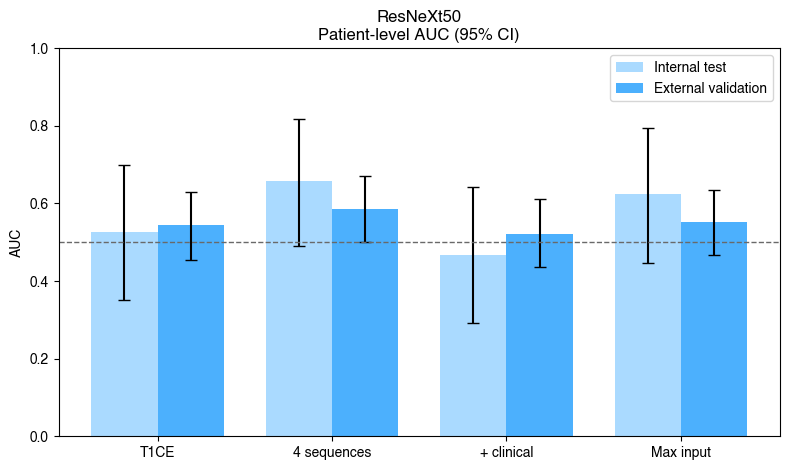

,arch,variant,internal_AUC,internal_Accuracy,internal_Precision,internal_Recall,internal_Specificity,internal_F1,internal_MCC,external_AUC,external_Accuracy,external_Precision,external_Recall,external_Specificity,external_F1,external_MCC
0,ResNeXt50,T1CE,"0.527 [0.351, 0.699]","0.548 [0.469, 0.628]","0.599 [0.508, 0.686]","0.738 [0.650, 0.826]","0.265 [0.161, 0.383]","0.661 [0.581, 0.734]","0.003 [-0.149, 0.163]","0.544 [0.455, 0.629]","0.494 [0.458, 0.531]","0.437 [0.392, 0.482]","0.759 [0.709, 0.806]","0.306 [0.263, 0.350]","0.553 [0.508, 0.595]","0.071 [-0.001, 0.144]"
1,ResNeXt50,4 sequences,"0.658 [0.489, 0.818]","0.637 [0.561, 0.713]","0.723 [0.623, 0.814]","0.638 [0.537, 0.736]","0.635 [0.508, 0.754]","0.678 [0.594, 0.754]","0.268 [0.110, 0.416]","0.586 [0.499, 0.669]","0.596 [0.559, 0.632]","0.517 [0.448, 0.587]","0.383 [0.324, 0.441]","0.746 [0.704, 0.787]","0.440 [0.380, 0.495]","0.138 [0.062, 0.215]"
2,ResNeXt50,+ clinical,"0.466 [0.292, 0.642]","0.586 [0.510, 0.662]","0.628 [0.535, 0.714]","0.755 [0.663, 0.842]","0.333 [0.218, 0.459]","0.686 [0.605, 0.756]","0.097 [-0.061, 0.259]","0.522 [0.437, 0.611]","0.526 [0.488, 0.563]","0.451 [0.403, 0.497]","0.652 [0.599, 0.705]","0.437 [0.388, 0.485]","0.533 [0.487, 0.575]","0.090 [0.013, 0.162]"
3,ResNeXt50,Max input,"0.625 [0.446, 0.795]","0.701 [0.624, 0.771]","0.797 [0.705, 0.882]","0.670 [0.570, 0.767]","0.746 [0.629, 0.852]","0.728 [0.644, 0.796]","0.408 [0.259, 0.546]","0.553 [0.466, 0.635]","0.571 [0.535, 0.609]","0.483 [0.423, 0.542]","0.500 [0.442, 0.560]","0.621 [0.573, 0.670]","0.491 [0.439, 0.543]","0.120 [0.048, 0.197]"


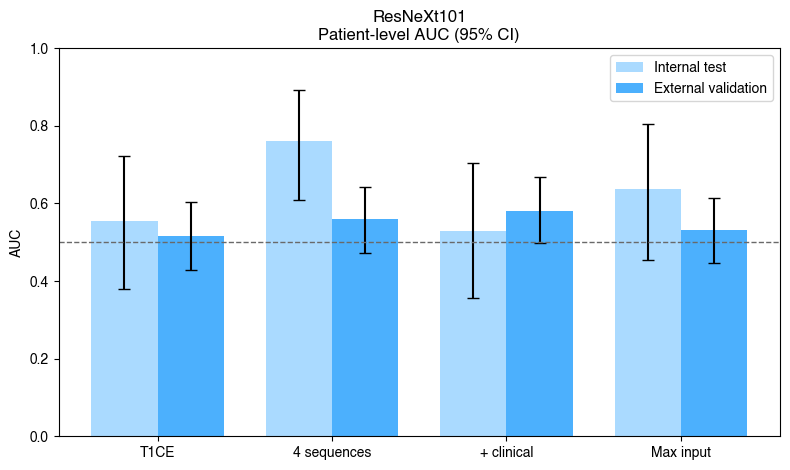

,arch,variant,internal_AUC,internal_Accuracy,internal_Precision,internal_Recall,internal_Specificity,internal_F1,internal_MCC,external_AUC,external_Accuracy,external_Precision,external_Recall,external_Specificity,external_F1,external_MCC
0,ResNeXt101,T1CE,"0.555 [0.379, 0.722]","0.569 [0.493, 0.648]","0.621 [0.525, 0.712]","0.713 [0.624, 0.802]","0.354 [0.239, 0.477]","0.661 [0.581, 0.732]","0.075 [-0.083, 0.233]","0.517 [0.428, 0.603]","0.499 [0.461, 0.536]","0.436 [0.391, 0.481]","0.723 [0.675, 0.773]","0.339 [0.295, 0.385]","0.542 [0.499, 0.583]","0.071 [-0.000, 0.143]"
1,ResNeXt101,4 sequences,"0.761 [0.608, 0.892]","0.707 [0.637, 0.771]","0.735 [0.643, 0.817]","0.798 [0.711, 0.874]","0.571 [0.444, 0.694]","0.765 [0.693, 0.824]","0.379 [0.227, 0.524]","0.560 [0.472, 0.641]","0.512 [0.473, 0.549]","0.444 [0.395, 0.490]","0.702 [0.647, 0.755]","0.377 [0.327, 0.426]","0.544 [0.497, 0.586]","0.082 [0.004, 0.154]"
2,ResNeXt101,+ clinical,"0.530 [0.357, 0.704]","0.618 [0.541, 0.694]","0.649 [0.559, 0.735]","0.787 [0.705, 0.867]","0.365 [0.250, 0.492]","0.712 [0.637, 0.776]","0.167 [0.013, 0.322]","0.580 [0.499, 0.667]","0.554 [0.518, 0.591]","0.472 [0.419, 0.520]","0.617 [0.558, 0.673]","0.510 [0.463, 0.559]","0.535 [0.488, 0.578]","0.126 [0.052, 0.197]"
3,ResNeXt101,Max input,"0.637 [0.455, 0.806]","0.682 [0.605, 0.752]","0.756 [0.662, 0.840]","0.691 [0.598, 0.782]","0.667 [0.549, 0.781]","0.722 [0.644, 0.791]","0.353 [0.199, 0.495]","0.531 [0.445, 0.615]","0.531 [0.494, 0.569]","0.446 [0.392, 0.500]","0.543 [0.485, 0.601]","0.523 [0.474, 0.574]","0.490 [0.441, 0.537]","0.064 [-0.010, 0.141]"


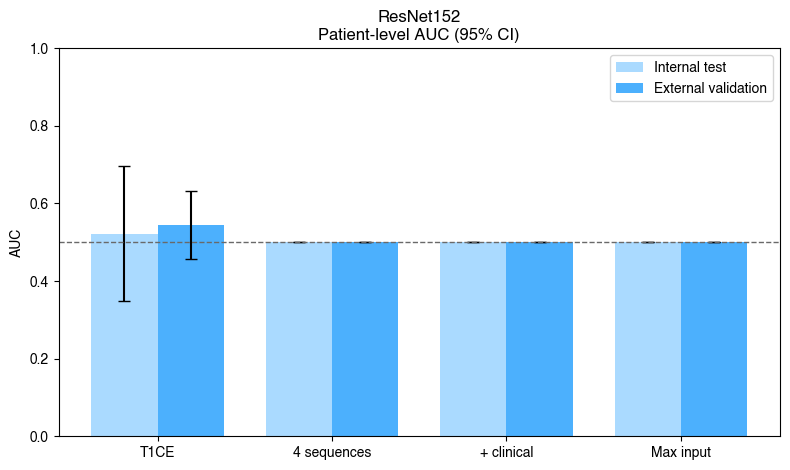

,arch,variant,internal_AUC,internal_Accuracy,internal_Precision,internal_Recall,internal_Specificity,internal_F1,internal_MCC,external_AUC,external_Accuracy,external_Precision,external_Recall,external_Specificity,external_F1,external_MCC
0,ResNet152,T1CE,"0.522 [0.349, 0.696]","0.577 [0.501, 0.656]","0.627 [0.532, 0.716]","0.730 [0.640, 0.821]","0.349 [0.234, 0.469]","0.675 [0.596, 0.745]","0.083 [-0.072, 0.242]","0.544 [0.456, 0.632]","0.512 [0.474, 0.548]","0.444 [0.399, 0.491]","0.700 [0.648, 0.752]","0.379 [0.331, 0.425]","0.543 [0.499, 0.586]","0.081 [0.007, 0.153]"
1,ResNet152,4 sequences,"0.500 [0.500, 0.500]","0.401 [0.331, 0.484]","0.000 [0.000, 0.000]","0.000 [0.000, 0.000]","1.000 [1.000, 1.000]","0.000 [0.000, 0.000]","0.000 [0.000, 0.000]","0.500 [0.500, 0.500]","0.585 [0.547, 0.622]","0.000 [0.000, 0.000]","0.000 [0.000, 0.000]","1.000 [1.000, 1.000]","0.000 [0.000, 0.000]","0.000 [0.000, 0.000]"
2,ResNet152,+ clinical,"0.500 [0.500, 0.500]","0.401 [0.331, 0.484]","0.000 [0.000, 0.000]","0.000 [0.000, 0.000]","1.000 [1.000, 1.000]","0.000 [0.000, 0.000]","0.000 [0.000, 0.000]","0.500 [0.500, 0.500]","0.585 [0.547, 0.622]","0.000 [0.000, 0.000]","0.000 [0.000, 0.000]","1.000 [1.000, 1.000]","0.000 [0.000, 0.000]","0.000 [0.000, 0.000]"
3,ResNet152,Max input,"0.500 [0.500, 0.500]","0.401 [0.331, 0.484]","0.000 [0.000, 0.000]","0.000 [0.000, 0.000]","1.000 [1.000, 1.000]","0.000 [0.000, 0.000]","0.000 [0.000, 0.000]","0.500 [0.500, 0.500]","0.585 [0.547, 0.622]","0.000 [0.000, 0.000]","0.000 [0.000, 0.000]","1.000 [1.000, 1.000]","0.000 [0.000, 0.000]","0.000 [0.000, 0.000]"


In [39]:
arch_order = ["ResNeXt50", "ResNeXt101", "ResNet152"]
variant_order = ["t1c", "4 seq", "clinical", "max_info"]

variant_label_map = {
    "t1c": "T1CE",
    "4 seq": "4 sequences",
    "clinical": "+ clinical",
    "max_info": "Max input",
}

plot_grouped_auc_with_tables(
    df_ci=df_ci,
    archs=arch_order,
    category_col="variant",
    category_order=variant_order,
    category_label_map=variant_label_map,
    merge_archs=False,
    table_mode="per_panel",
    per_panel_title_fmt="{arch}\nPatient-level AUC (95% CI)",
    decimals=3,
    include_numeric_cols=False,
)

### combined graphs

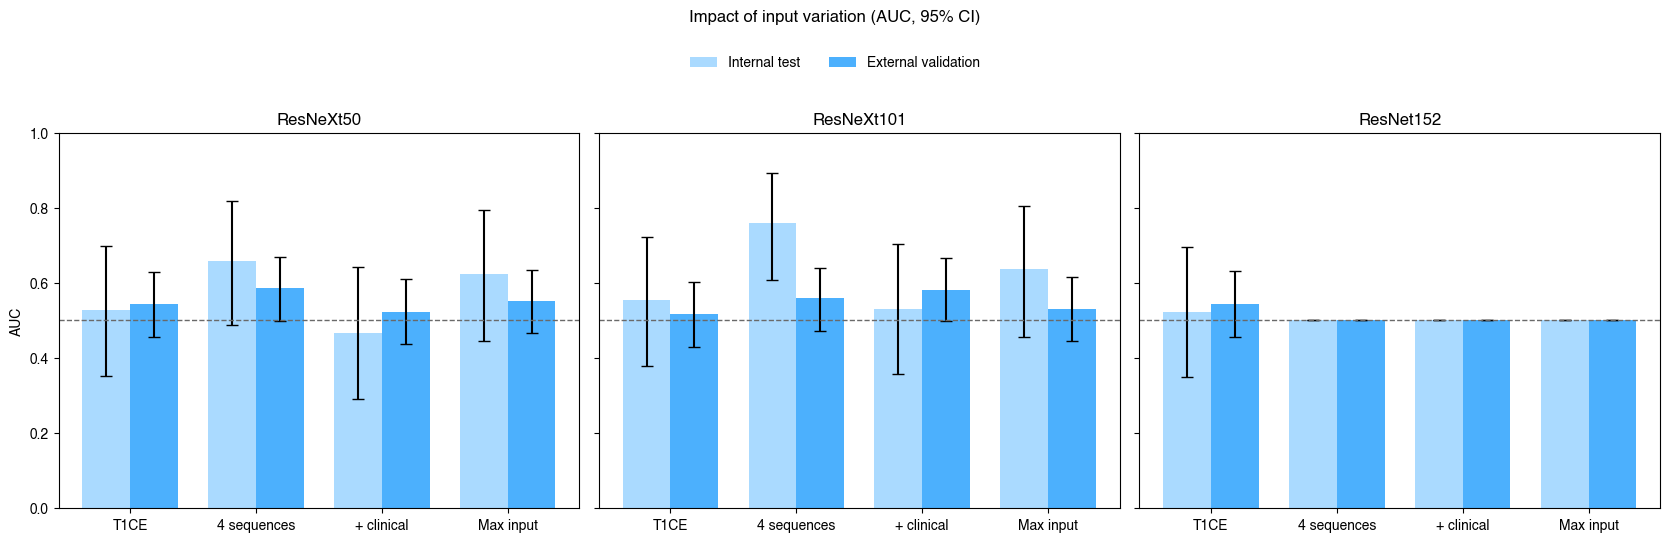

,arch,variant,internal_AUC,internal_Accuracy,internal_Precision,internal_Recall,internal_Specificity,internal_F1,internal_MCC,external_AUC,external_Accuracy,external_Precision,external_Recall,external_Specificity,external_F1,external_MCC
0,ResNeXt50,T1CE,"0.527 [0.351, 0.699]","0.548 [0.469, 0.628]","0.599 [0.508, 0.686]","0.738 [0.650, 0.826]","0.265 [0.161, 0.383]","0.661 [0.581, 0.734]","0.003 [-0.149, 0.163]","0.544 [0.455, 0.629]","0.494 [0.458, 0.531]","0.437 [0.392, 0.482]","0.759 [0.709, 0.806]","0.306 [0.263, 0.350]","0.553 [0.508, 0.595]","0.071 [-0.001, 0.144]"
1,ResNeXt50,4 sequences,"0.658 [0.489, 0.818]","0.637 [0.561, 0.713]","0.723 [0.623, 0.814]","0.638 [0.537, 0.736]","0.635 [0.508, 0.754]","0.678 [0.594, 0.754]","0.268 [0.110, 0.416]","0.586 [0.499, 0.669]","0.596 [0.559, 0.632]","0.517 [0.448, 0.587]","0.383 [0.324, 0.441]","0.746 [0.704, 0.787]","0.440 [0.380, 0.495]","0.138 [0.062, 0.215]"
2,ResNeXt50,+ clinical,"0.466 [0.292, 0.642]","0.586 [0.510, 0.662]","0.628 [0.535, 0.714]","0.755 [0.663, 0.842]","0.333 [0.218, 0.459]","0.686 [0.605, 0.756]","0.097 [-0.061, 0.259]","0.522 [0.437, 0.611]","0.526 [0.488, 0.563]","0.451 [0.403, 0.497]","0.652 [0.599, 0.705]","0.437 [0.388, 0.485]","0.533 [0.487, 0.575]","0.090 [0.013, 0.162]"
3,ResNeXt50,Max input,"0.625 [0.446, 0.795]","0.701 [0.624, 0.771]","0.797 [0.705, 0.882]","0.670 [0.570, 0.767]","0.746 [0.629, 0.852]","0.728 [0.644, 0.796]","0.408 [0.259, 0.546]","0.553 [0.466, 0.635]","0.571 [0.535, 0.609]","0.483 [0.423, 0.542]","0.500 [0.442, 0.560]","0.621 [0.573, 0.670]","0.491 [0.439, 0.543]","0.120 [0.048, 0.197]"
4,ResNeXt101,T1CE,"0.555 [0.379, 0.722]","0.569 [0.493, 0.648]","0.621 [0.525, 0.712]","0.713 [0.624, 0.802]","0.354 [0.239, 0.477]","0.661 [0.581, 0.732]","0.075 [-0.083, 0.233]","0.517 [0.428, 0.603]","0.499 [0.461, 0.536]","0.436 [0.391, 0.481]","0.723 [0.675, 0.773]","0.339 [0.295, 0.385]","0.542 [0.499, 0.583]","0.071 [-0.000, 0.143]"
5,ResNeXt101,4 sequences,"0.761 [0.608, 0.892]","0.707 [0.637, 0.771]","0.735 [0.643, 0.817]","0.798 [0.711, 0.874]","0.571 [0.444, 0.694]","0.765 [0.693, 0.824]","0.379 [0.227, 0.524]","0.560 [0.472, 0.641]","0.512 [0.473, 0.549]","0.444 [0.395, 0.490]","0.702 [0.647, 0.755]","0.377 [0.327, 0.426]","0.544 [0.497, 0.586]","0.082 [0.004, 0.154]"
6,ResNeXt101,+ clinical,"0.530 [0.357, 0.704]","0.618 [0.541, 0.694]","0.649 [0.559, 0.735]","0.787 [0.705, 0.867]","0.365 [0.250, 0.492]","0.712 [0.637, 0.776]","0.167 [0.013, 0.322]","0.580 [0.499, 0.667]","0.554 [0.518, 0.591]","0.472 [0.419, 0.520]","0.617 [0.558, 0.673]","0.510 [0.463, 0.559]","0.535 [0.488, 0.578]","0.126 [0.052, 0.197]"
7,ResNeXt101,Max input,"0.637 [0.455, 0.806]","0.682 [0.605, 0.752]","0.756 [0.662, 0.840]","0.691 [0.598, 0.782]","0.667 [0.549, 0.781]","0.722 [0.644, 0.791]","0.353 [0.199, 0.495]","0.531 [0.445, 0.615]","0.531 [0.494, 0.569]","0.446 [0.392, 0.500]","0.543 [0.485, 0.601]","0.523 [0.474, 0.574]","0.490 [0.441, 0.537]","0.064 [-0.010, 0.141]"
8,ResNet152,T1CE,"0.522 [0.349, 0.696]","0.577 [0.501, 0.656]","0.627 [0.532, 0.716]","0.730 [0.640, 0.821]","0.349 [0.234, 0.469]","0.675 [0.596, 0.745]","0.083 [-0.072, 0.242]","0.544 [0.456, 0.632]","0.512 [0.474, 0.548]","0.444 [0.399, 0.491]","0.700 [0.648, 0.752]","0.379 [0.331, 0.425]","0.543 [0.499, 0.586]","0.081 [0.007, 0.153]"
9,ResNet152,4 sequences,"0.500 [0.500, 0.500]","0.401 [0.331, 0.484]","0.000 [0.000, 0.000]","0.000 [0.000, 0.000]","1.000 [1.000, 1.000]","0.000 [0.000, 0.000]","0.000 [0.000, 0.000]","0.500 [0.500, 0.500]","0.585 [0.547, 0.622]","0.000 [0.000, 0.000]","0.000 [0.000, 0.000]","1.000 [1.000, 1.000]","0.000 [0.000, 0.000]","0.000 [0.000, 0.000]"


,arch,variant,internal_AUC,internal_Accuracy,internal_Precision,internal_Recall,internal_Specificity,internal_F1,internal_MCC,external_AUC,external_Accuracy,external_Precision,external_Recall,external_Specificity,external_F1,external_MCC
0,ResNeXt50,T1CE,"0.527 [0.351, 0.699]","0.548 [0.469, 0.628]","0.599 [0.508, 0.686]","0.738 [0.650, 0.826]","0.265 [0.161, 0.383]","0.661 [0.581, 0.734]","0.003 [-0.149, 0.163]","0.544 [0.455, 0.629]","0.494 [0.458, 0.531]","0.437 [0.392, 0.482]","0.759 [0.709, 0.806]","0.306 [0.263, 0.350]","0.553 [0.508, 0.595]","0.071 [-0.001, 0.144]"
1,ResNeXt50,4 sequences,"0.658 [0.489, 0.818]","0.637 [0.561, 0.713]","0.723 [0.623, 0.814]","0.638 [0.537, 0.736]","0.635 [0.508, 0.754]","0.678 [0.594, 0.754]","0.268 [0.110, 0.416]","0.586 [0.499, 0.669]","0.596 [0.559, 0.632]","0.517 [0.448, 0.587]","0.383 [0.324, 0.441]","0.746 [0.704, 0.787]","0.440 [0.380, 0.495]","0.138 [0.062, 0.215]"
2,ResNeXt50,+ clinical,"0.466 [0.292, 0.642]","0.586 [0.510, 0.662]","0.628 [0.535, 0.714]","0.755 [0.663, 0.842]","0.333 [0.218, 0.459]","0.686 [0.605, 0.756]","0.097 [-0.061, 0.259]","0.522 [0.437, 0.611]","0.526 [0.488, 0.563]","0.451 [0.403, 0.497]","0.652 [0.599, 0.705]","0.437 [0.388, 0.485]","0.533 [0.487, 0.575]","0.090 [0.013, 0.162]"
3,ResNeXt50,Max input,"0.625 [0.446, 0.795]","0.701 [0.624, 0.771]","0.797 [0.705, 0.882]","0.670 [0.570, 0.767]","0.746 [0.629, 0.852]","0.728 [0.644, 0.796]","0.408 [0.259, 0.546]","0.553 [0.466, 0.635]","0.571 [0.535, 0.609]","0.483 [0.423, 0.542]","0.500 [0.442, 0.560]","0.621 [0.573, 0.670]","0.491 [0.439, 0.543]","0.120 [0.048, 0.197]"
4,ResNeXt101,T1CE,"0.555 [0.379, 0.722]","0.569 [0.493, 0.648]","0.621 [0.525, 0.712]","0.713 [0.624, 0.802]","0.354 [0.239, 0.477]","0.661 [0.581, 0.732]","0.075 [-0.083, 0.233]","0.517 [0.428, 0.603]","0.499 [0.461, 0.536]","0.436 [0.391, 0.481]","0.723 [0.675, 0.773]","0.339 [0.295, 0.385]","0.542 [0.499, 0.583]","0.071 [-0.000, 0.143]"
5,ResNeXt101,4 sequences,"0.761 [0.608, 0.892]","0.707 [0.637, 0.771]","0.735 [0.643, 0.817]","0.798 [0.711, 0.874]","0.571 [0.444, 0.694]","0.765 [0.693, 0.824]","0.379 [0.227, 0.524]","0.560 [0.472, 0.641]","0.512 [0.473, 0.549]","0.444 [0.395, 0.490]","0.702 [0.647, 0.755]","0.377 [0.327, 0.426]","0.544 [0.497, 0.586]","0.082 [0.004, 0.154]"
6,ResNeXt101,+ clinical,"0.530 [0.357, 0.704]","0.618 [0.541, 0.694]","0.649 [0.559, 0.735]","0.787 [0.705, 0.867]","0.365 [0.250, 0.492]","0.712 [0.637, 0.776]","0.167 [0.013, 0.322]","0.580 [0.499, 0.667]","0.554 [0.518, 0.591]","0.472 [0.419, 0.520]","0.617 [0.558, 0.673]","0.510 [0.463, 0.559]","0.535 [0.488, 0.578]","0.126 [0.052, 0.197]"
7,ResNeXt101,Max input,"0.637 [0.455, 0.806]","0.682 [0.605, 0.752]","0.756 [0.662, 0.840]","0.691 [0.598, 0.782]","0.667 [0.549, 0.781]","0.722 [0.644, 0.791]","0.353 [0.199, 0.495]","0.531 [0.445, 0.615]","0.531 [0.494, 0.569]","0.446 [0.392, 0.500]","0.543 [0.485, 0.601]","0.523 [0.474, 0.574]","0.490 [0.441, 0.537]","0.064 [-0.010, 0.141]"
8,ResNet152,T1CE,"0.522 [0.349, 0.696]","0.577 [0.501, 0.656]","0.627 [0.532, 0.716]","0.730 [0.640, 0.821]","0.349 [0.234, 0.469]","0.675 [0.596, 0.745]","0.083 [-0.072, 0.242]","0.544 [0.456, 0.632]","0.512 [0.474, 0.548]","0.444 [0.399, 0.491]","0.700 [0.648, 0.752]","0.379 [0.331, 0.425]","0.543 [0.499, 0.586]","0.081 [0.007, 0.153]"
9,ResNet152,4 sequences,"0.500 [0.500, 0.500]","0.401 [0.331, 0.484]","0.000 [0.000, 0.000]","0.000 [0.000, 0.000]","1.000 [1.000, 1.000]","0.000 [0.000, 0.000]","0.000 [0.000, 0.000]","0.500 [0.500, 0.500]","0.585 [0.547, 0.622]","0.000 [0.000, 0.000]","0.000 [0.000, 0.000]","1.000 [1.000, 1.000]","0.000 [0.000, 0.000]","0.000 [0.000, 0.000]"


In [40]:
arch_order = ["ResNeXt50", "ResNeXt101", "ResNet152"]

# plot_grouped_auc_with_table(
#     df_ci=df_ci,
#     archs=arch_order,
#     category_col="variant",
#     category_order=variant_order,
#     category_label_map=variant_label_map,
#     merge_archs=True,
#     table_mode="combined",  # or "per_panel" or "none"
#     suptitle="Impact of input variation (AUC, 95% CI)"
# )

plot_grouped_auc_with_tables(
    df_ci=df_ci,
    archs=arch_order,
    category_col="variant",
    category_order=variant_order,
    category_label_map=variant_label_map,
    merge_archs=True,
    table_mode="combined",
    suptitle="Impact of input variation (AUC, 95% CI)",
    decimals=3,
    include_numeric_cols=False,
)

## Pretraining variation graphs
### separate graphs

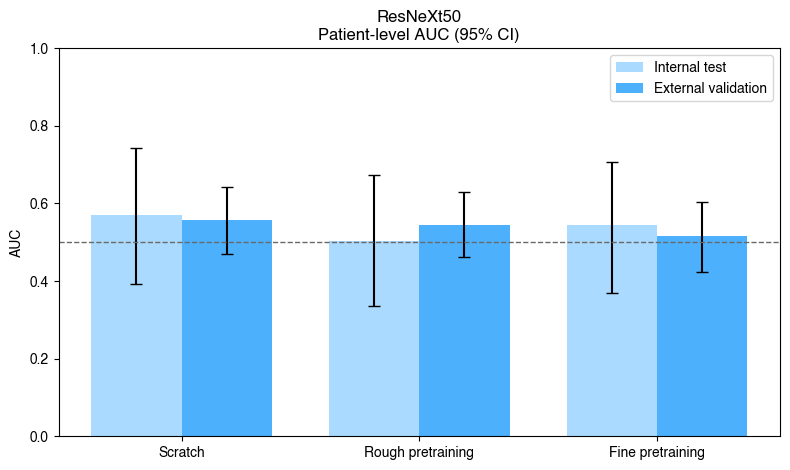

,arch,strategy,internal_AUC,internal_Accuracy,internal_Precision,internal_Recall,internal_Specificity,internal_F1,internal_MCC,external_AUC,external_Accuracy,external_Precision,external_Recall,external_Specificity,external_F1,external_MCC
0,ResNeXt50,Scratch,"0.571 [0.394, 0.743]","0.611 [0.535, 0.688]","0.684 [0.589, 0.772]","0.689 [0.592, 0.783]","0.496 [0.381, 0.612]","0.682 [0.599, 0.754]","0.183 [0.029, 0.334]","0.558 [0.470, 0.643]","0.550 [0.513, 0.587]","0.474 [0.419, 0.529]","0.583 [0.528, 0.637]","0.526 [0.480, 0.571]","0.509 [0.459, 0.557]","0.114 [0.040, 0.189]"
1,ResNeXt50,Rough pretraining,"0.504 [0.335, 0.674]","0.561 [0.478, 0.637]","0.603 [0.513, 0.686]","0.777 [0.691, 0.859]","0.238 [0.138, 0.354]","0.679 [0.600, 0.747]","0.017 [-0.137, 0.179]","0.546 [0.463, 0.628]","0.459 [0.423, 0.497]","0.422 [0.381, 0.465]","0.826 [0.782, 0.866]","0.198 [0.162, 0.238]","0.559 [0.516, 0.599]","0.031 [-0.040, 0.105]"
2,ResNeXt50,Fine pretraining,"0.543 [0.370, 0.707]","0.561 [0.484, 0.643]","0.609 [0.519, 0.695]","0.745 [0.660, 0.832]","0.286 [0.177, 0.409]","0.670 [0.592, 0.743]","0.034 [-0.115, 0.196]","0.515 [0.424, 0.604]","0.516 [0.479, 0.554]","0.443 [0.394, 0.491]","0.652 [0.595, 0.708]","0.420 [0.373, 0.469]","0.528 [0.480, 0.571]","0.073 [-0.001, 0.146]"


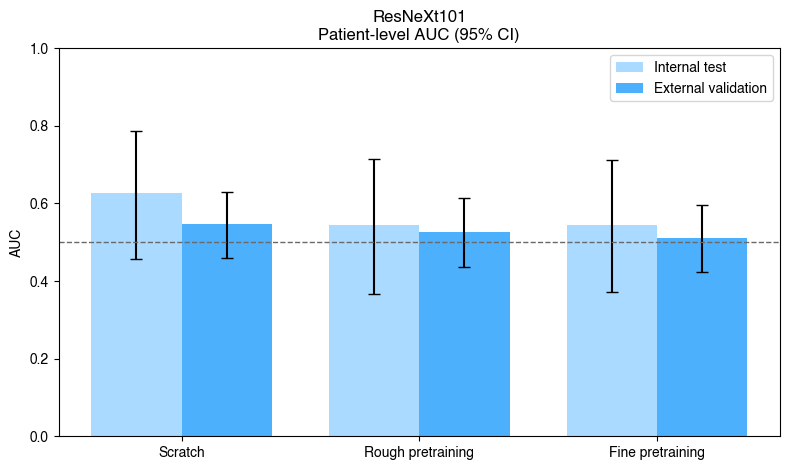

,arch,strategy,internal_AUC,internal_Accuracy,internal_Precision,internal_Recall,internal_Specificity,internal_F1,internal_MCC,external_AUC,external_Accuracy,external_Precision,external_Recall,external_Specificity,external_F1,external_MCC
0,ResNeXt101,Scratch,"0.626 [0.456, 0.785]","0.651 [0.576, 0.723]","0.694 [0.602, 0.777]","0.763 [0.676, 0.846]","0.484 [0.366, 0.604]","0.724 [0.649, 0.789]","0.255 [0.100, 0.404]","0.546 [0.460, 0.630]","0.522 [0.485, 0.560]","0.451 [0.402, 0.498]","0.681 [0.628, 0.732]","0.410 [0.363, 0.458]","0.538 [0.492, 0.581]","0.097 [0.022, 0.169]"
1,ResNeXt101,Rough pretraining,"0.544 [0.366, 0.713]","0.586 [0.510, 0.662]","0.622 [0.532, 0.706]","0.787 [0.705, 0.870]","0.286 [0.175, 0.406]","0.695 [0.622, 0.762]","0.083 [-0.073, 0.243]","0.526 [0.437, 0.615]","0.510 [0.474, 0.549]","0.443 [0.397, 0.490]","0.702 [0.652, 0.755]","0.374 [0.328, 0.422]","0.543 [0.499, 0.586]","0.079 [0.010, 0.153]"
2,ResNeXt101,Fine pretraining,"0.544 [0.371, 0.712]","0.522 [0.446, 0.605]","0.607 [0.500, 0.711]","0.574 [0.476, 0.674]","0.444 [0.322, 0.574]","0.590 [0.500, 0.670]","0.019 [-0.139, 0.183]","0.511 [0.424, 0.595]","0.493 [0.456, 0.529]","0.422 [0.375, 0.470]","0.606 [0.552, 0.663]","0.412 [0.365, 0.461]","0.498 [0.453, 0.541]","0.019 [-0.054, 0.093]"


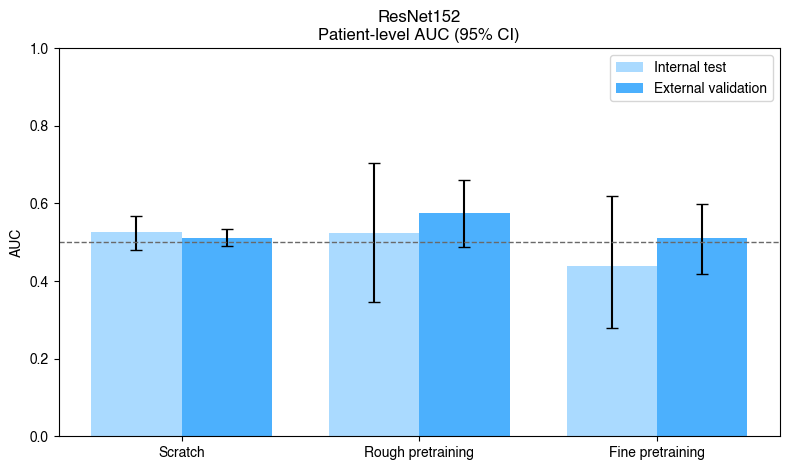

,arch,strategy,internal_AUC,internal_Accuracy,internal_Precision,internal_Recall,internal_Specificity,internal_F1,internal_MCC,external_AUC,external_Accuracy,external_Precision,external_Recall,external_Specificity,external_F1,external_MCC
0,ResNet152,Scratch,"0.526 [0.480, 0.567]","0.451 [0.379, 0.532]","0.161 [0.136, 0.183]","0.186 [0.164, 0.208]","0.845 [0.815, 0.875]","0.172 [0.153, 0.190]","0.033 [-0.007, 0.073]","0.512 [0.491, 0.534]","0.564 [0.526, 0.600]","0.109 [0.098, 0.120]","0.177 [0.164, 0.190]","0.837 [0.826, 0.849]","0.135 [0.124, 0.146]","0.015 [-0.003, 0.034]"
1,ResNet152,Rough pretraining,"0.525 [0.345, 0.703]","0.592 [0.516, 0.675]","0.644 [0.547, 0.735]","0.713 [0.621, 0.804]","0.413 [0.293, 0.540]","0.677 [0.597, 0.749]","0.130 [-0.024, 0.287]","0.574 [0.489, 0.661]","0.537 [0.497, 0.574]","0.460 [0.411, 0.510]","0.674 [0.621, 0.726]","0.440 [0.391, 0.486]","0.547 [0.502, 0.592]","0.114 [0.038, 0.186]"
2,ResNet152,Fine pretraining,"0.439 [0.280, 0.618]","0.541 [0.465, 0.618]","0.595 [0.504, 0.681]","0.734 [0.642, 0.825]","0.254 [0.149, 0.368]","0.657 [0.579, 0.727]","-0.013 [-0.164, 0.147]","0.510 [0.418, 0.598]","0.500 [0.463, 0.537]","0.437 [0.394, 0.482]","0.716 [0.667, 0.770]","0.347 [0.298, 0.392]","0.543 [0.501, 0.584]","0.067 [-0.007, 0.140]"


In [44]:
strategy_order = ["scratch", "rough", "fine"]

strategy_label_map = {
    "scratch": "Scratch",
    "rough": "Rough pretraining",
    "fine": "Fine pretraining",
}

# If you want to restrict pretraining comparison to T1c only (recommended if that's how you trained it):
# df_ci_t1c = df_ci[df_ci["variant"] == "t1c"].copy()
df_ci_t1c = df_ci  # keep as-is unless you want strict t1c-only comparison

arch_order = ["ResNeXt50", "ResNeXt101", "ResNet152"]
# plot_grouped_auc_with_table(
#     df_ci=df_ci_t1c,
#     archs=arch_order,
#     category_col="strategy",
#     merge_archs=False,
#     category_order=strategy_order,
#     category_label_map=strategy_label_map,
#     per_panel_title_fmt="{arch}\nPatient-level AUC (95% CI)",
#     decimals=3,
# )

plot_grouped_auc_with_tables(
    df_ci=df_ci,
    archs=arch_order,
    category_col="strategy",
    category_order=strategy_order,
    category_label_map=strategy_label_map,
    merge_archs=False,
    table_mode="per_panel",
    per_panel_title_fmt="{arch}\nPatient-level AUC (95% CI)",
    decimals=3,
    include_numeric_cols=False,
)

### combined graphs

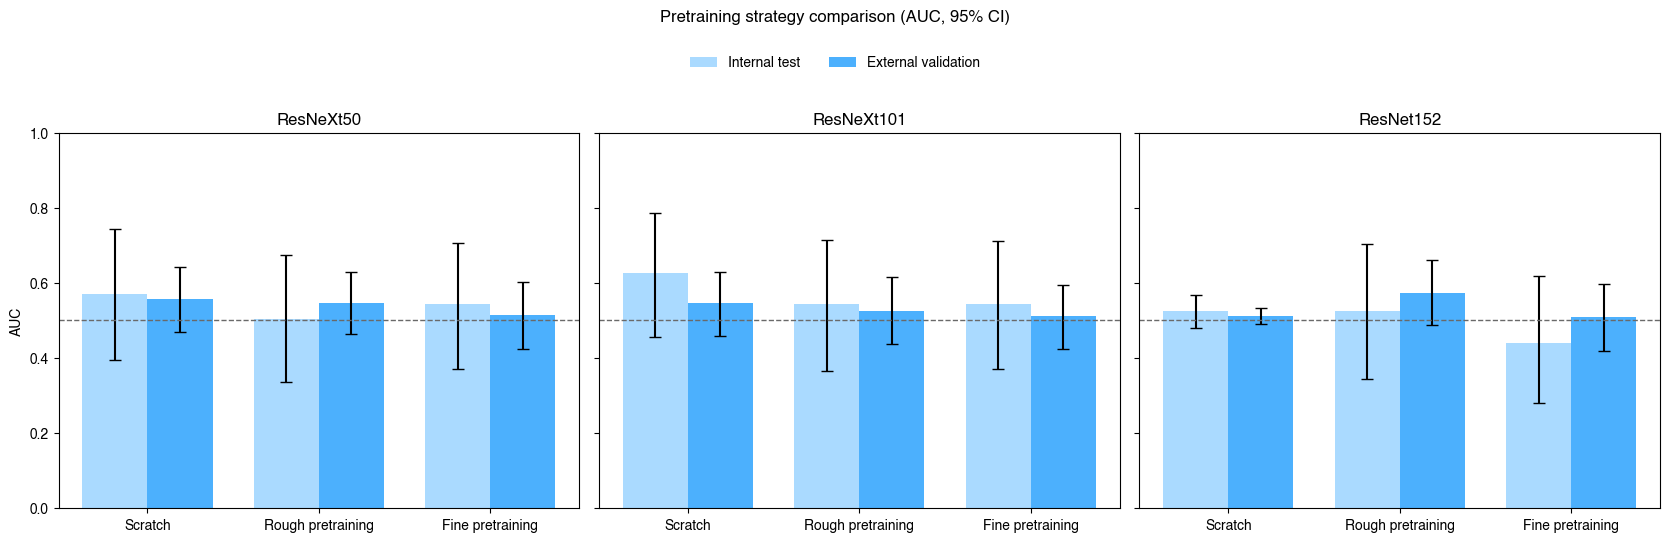

,arch,strategy,internal_AUC,internal_Accuracy,internal_Precision,internal_Recall,internal_Specificity,internal_F1,internal_MCC,external_AUC,external_Accuracy,external_Precision,external_Recall,external_Specificity,external_F1,external_MCC
0,ResNeXt50,Scratch,"0.571 [0.394, 0.743]","0.611 [0.535, 0.688]","0.684 [0.589, 0.772]","0.689 [0.592, 0.783]","0.496 [0.381, 0.612]","0.682 [0.599, 0.754]","0.183 [0.029, 0.334]","0.558 [0.470, 0.643]","0.550 [0.513, 0.587]","0.474 [0.419, 0.529]","0.583 [0.528, 0.637]","0.526 [0.480, 0.571]","0.509 [0.459, 0.557]","0.114 [0.040, 0.189]"
1,ResNeXt50,Rough pretraining,"0.504 [0.335, 0.674]","0.561 [0.478, 0.637]","0.603 [0.513, 0.686]","0.777 [0.691, 0.859]","0.238 [0.138, 0.354]","0.679 [0.600, 0.747]","0.017 [-0.137, 0.179]","0.546 [0.463, 0.628]","0.459 [0.423, 0.497]","0.422 [0.381, 0.465]","0.826 [0.782, 0.866]","0.198 [0.162, 0.238]","0.559 [0.516, 0.599]","0.031 [-0.040, 0.105]"
2,ResNeXt50,Fine pretraining,"0.543 [0.370, 0.707]","0.561 [0.484, 0.643]","0.609 [0.519, 0.695]","0.745 [0.660, 0.832]","0.286 [0.177, 0.409]","0.670 [0.592, 0.743]","0.034 [-0.115, 0.196]","0.515 [0.424, 0.604]","0.516 [0.479, 0.554]","0.443 [0.394, 0.491]","0.652 [0.595, 0.708]","0.420 [0.373, 0.469]","0.528 [0.480, 0.571]","0.073 [-0.001, 0.146]"
3,ResNeXt101,Scratch,"0.626 [0.456, 0.785]","0.651 [0.576, 0.723]","0.694 [0.602, 0.777]","0.763 [0.676, 0.846]","0.484 [0.366, 0.604]","0.724 [0.649, 0.789]","0.255 [0.100, 0.404]","0.546 [0.460, 0.630]","0.522 [0.485, 0.560]","0.451 [0.402, 0.498]","0.681 [0.628, 0.732]","0.410 [0.363, 0.458]","0.538 [0.492, 0.581]","0.097 [0.022, 0.169]"
4,ResNeXt101,Rough pretraining,"0.544 [0.366, 0.713]","0.586 [0.510, 0.662]","0.622 [0.532, 0.706]","0.787 [0.705, 0.870]","0.286 [0.175, 0.406]","0.695 [0.622, 0.762]","0.083 [-0.073, 0.243]","0.526 [0.437, 0.615]","0.510 [0.474, 0.549]","0.443 [0.397, 0.490]","0.702 [0.652, 0.755]","0.374 [0.328, 0.422]","0.543 [0.499, 0.586]","0.079 [0.010, 0.153]"
5,ResNeXt101,Fine pretraining,"0.544 [0.371, 0.712]","0.522 [0.446, 0.605]","0.607 [0.500, 0.711]","0.574 [0.476, 0.674]","0.444 [0.322, 0.574]","0.590 [0.500, 0.670]","0.019 [-0.139, 0.183]","0.511 [0.424, 0.595]","0.493 [0.456, 0.529]","0.422 [0.375, 0.470]","0.606 [0.552, 0.663]","0.412 [0.365, 0.461]","0.498 [0.453, 0.541]","0.019 [-0.054, 0.093]"
6,ResNet152,Scratch,"0.526 [0.480, 0.567]","0.451 [0.379, 0.532]","0.161 [0.136, 0.183]","0.186 [0.164, 0.208]","0.845 [0.815, 0.875]","0.172 [0.153, 0.190]","0.033 [-0.007, 0.073]","0.512 [0.491, 0.534]","0.564 [0.526, 0.600]","0.109 [0.098, 0.120]","0.177 [0.164, 0.190]","0.837 [0.826, 0.849]","0.135 [0.124, 0.146]","0.015 [-0.003, 0.034]"
7,ResNet152,Rough pretraining,"0.525 [0.345, 0.703]","0.592 [0.516, 0.675]","0.644 [0.547, 0.735]","0.713 [0.621, 0.804]","0.413 [0.293, 0.540]","0.677 [0.597, 0.749]","0.130 [-0.024, 0.287]","0.574 [0.489, 0.661]","0.537 [0.497, 0.574]","0.460 [0.411, 0.510]","0.674 [0.621, 0.726]","0.440 [0.391, 0.486]","0.547 [0.502, 0.592]","0.114 [0.038, 0.186]"
8,ResNet152,Fine pretraining,"0.439 [0.280, 0.618]","0.541 [0.465, 0.618]","0.595 [0.504, 0.681]","0.734 [0.642, 0.825]","0.254 [0.149, 0.368]","0.657 [0.579, 0.727]","-0.013 [-0.164, 0.147]","0.510 [0.418, 0.598]","0.500 [0.463, 0.537]","0.437 [0.394, 0.482]","0.716 [0.667, 0.770]","0.347 [0.298, 0.392]","0.543 [0.501, 0.584]","0.067 [-0.007, 0.140]"


,arch,strategy,internal_AUC,internal_Accuracy,internal_Precision,internal_Recall,internal_Specificity,internal_F1,internal_MCC,external_AUC,external_Accuracy,external_Precision,external_Recall,external_Specificity,external_F1,external_MCC
0,ResNeXt50,Scratch,"0.571 [0.394, 0.743]","0.611 [0.535, 0.688]","0.684 [0.589, 0.772]","0.689 [0.592, 0.783]","0.496 [0.381, 0.612]","0.682 [0.599, 0.754]","0.183 [0.029, 0.334]","0.558 [0.470, 0.643]","0.550 [0.513, 0.587]","0.474 [0.419, 0.529]","0.583 [0.528, 0.637]","0.526 [0.480, 0.571]","0.509 [0.459, 0.557]","0.114 [0.040, 0.189]"
1,ResNeXt50,Rough pretraining,"0.504 [0.335, 0.674]","0.561 [0.478, 0.637]","0.603 [0.513, 0.686]","0.777 [0.691, 0.859]","0.238 [0.138, 0.354]","0.679 [0.600, 0.747]","0.017 [-0.137, 0.179]","0.546 [0.463, 0.628]","0.459 [0.423, 0.497]","0.422 [0.381, 0.465]","0.826 [0.782, 0.866]","0.198 [0.162, 0.238]","0.559 [0.516, 0.599]","0.031 [-0.040, 0.105]"
2,ResNeXt50,Fine pretraining,"0.543 [0.370, 0.707]","0.561 [0.484, 0.643]","0.609 [0.519, 0.695]","0.745 [0.660, 0.832]","0.286 [0.177, 0.409]","0.670 [0.592, 0.743]","0.034 [-0.115, 0.196]","0.515 [0.424, 0.604]","0.516 [0.479, 0.554]","0.443 [0.394, 0.491]","0.652 [0.595, 0.708]","0.420 [0.373, 0.469]","0.528 [0.480, 0.571]","0.073 [-0.001, 0.146]"
3,ResNeXt101,Scratch,"0.626 [0.456, 0.785]","0.651 [0.576, 0.723]","0.694 [0.602, 0.777]","0.763 [0.676, 0.846]","0.484 [0.366, 0.604]","0.724 [0.649, 0.789]","0.255 [0.100, 0.404]","0.546 [0.460, 0.630]","0.522 [0.485, 0.560]","0.451 [0.402, 0.498]","0.681 [0.628, 0.732]","0.410 [0.363, 0.458]","0.538 [0.492, 0.581]","0.097 [0.022, 0.169]"
4,ResNeXt101,Rough pretraining,"0.544 [0.366, 0.713]","0.586 [0.510, 0.662]","0.622 [0.532, 0.706]","0.787 [0.705, 0.870]","0.286 [0.175, 0.406]","0.695 [0.622, 0.762]","0.083 [-0.073, 0.243]","0.526 [0.437, 0.615]","0.510 [0.474, 0.549]","0.443 [0.397, 0.490]","0.702 [0.652, 0.755]","0.374 [0.328, 0.422]","0.543 [0.499, 0.586]","0.079 [0.010, 0.153]"
5,ResNeXt101,Fine pretraining,"0.544 [0.371, 0.712]","0.522 [0.446, 0.605]","0.607 [0.500, 0.711]","0.574 [0.476, 0.674]","0.444 [0.322, 0.574]","0.590 [0.500, 0.670]","0.019 [-0.139, 0.183]","0.511 [0.424, 0.595]","0.493 [0.456, 0.529]","0.422 [0.375, 0.470]","0.606 [0.552, 0.663]","0.412 [0.365, 0.461]","0.498 [0.453, 0.541]","0.019 [-0.054, 0.093]"
6,ResNet152,Scratch,"0.526 [0.480, 0.567]","0.451 [0.379, 0.532]","0.161 [0.136, 0.183]","0.186 [0.164, 0.208]","0.845 [0.815, 0.875]","0.172 [0.153, 0.190]","0.033 [-0.007, 0.073]","0.512 [0.491, 0.534]","0.564 [0.526, 0.600]","0.109 [0.098, 0.120]","0.177 [0.164, 0.190]","0.837 [0.826, 0.849]","0.135 [0.124, 0.146]","0.015 [-0.003, 0.034]"
7,ResNet152,Rough pretraining,"0.525 [0.345, 0.703]","0.592 [0.516, 0.675]","0.644 [0.547, 0.735]","0.713 [0.621, 0.804]","0.413 [0.293, 0.540]","0.677 [0.597, 0.749]","0.130 [-0.024, 0.287]","0.574 [0.489, 0.661]","0.537 [0.497, 0.574]","0.460 [0.411, 0.510]","0.674 [0.621, 0.726]","0.440 [0.391, 0.486]","0.547 [0.502, 0.592]","0.114 [0.038, 0.186]"
8,ResNet152,Fine pretraining,"0.439 [0.280, 0.618]","0.541 [0.465, 0.618]","0.595 [0.504, 0.681]","0.734 [0.642, 0.825]","0.254 [0.149, 0.368]","0.657 [0.579, 0.727]","-0.013 [-0.164, 0.147]","0.510 [0.418, 0.598]","0.500 [0.463, 0.537]","0.437 [0.394, 0.482]","0.716 [0.667, 0.770]","0.347 [0.298, 0.392]","0.543 [0.501, 0.584]","0.067 [-0.007, 0.140]"


In [42]:
strategy_order = ["scratch", "rough", "fine"]
strategy_label_map = {
    "scratch": "Scratch",
    "rough": "Rough pretraining",
    "fine": "Fine pretraining",
}

# plot_grouped_auc_with_table(
#     df_ci=df_ci,
#     archs=arch_order,
#     category_col="strategy",
#     category_order=strategy_order,
#     category_label_map=strategy_label_map,
#     merge_archs=True,
#     table_mode="combined",
#     suptitle="Pretraining strategy comparison (AUC, 95% CI)"
# )

plot_grouped_auc_with_tables(
    df_ci=df_ci,
    archs=arch_order,
    category_col="strategy",
    category_order=strategy_order,
    category_label_map=strategy_label_map,
    merge_archs=True,
    table_mode="combined",
    suptitle="Pretraining strategy comparison (AUC, 95% CI)",
    decimals=3,
    include_numeric_cols=False,
)

# Lesion Level CI
## Input Variation Plots

In [18]:
path_to_evals_lesion_level = Path("/Users/LennartPhilipp/Desktop/Uni/Prowiss/Training/Evaluations/eval_internal_external_lesion_level_23_02_26")

lesion_level_runs = [f for f in path_to_evals_lesion_level.iterdir() if f.is_dir() and f.name.startswith("lung_vs_nolung")]
lesion_level_runs_dict = {
    r.name.removeprefix("lung_vs_nolung_2cls_"): r
    for r in lesion_level_runs
}

print("Found runs:")
lesion_level_runs_dict

Found runs:


{'t1c_fine_resnet152_lesion_23_02_2026': PosixPath('/Users/LennartPhilipp/Desktop/Uni/Prowiss/Training/Evaluations/eval_internal_external_lesion_level_23_02_26/lung_vs_nolung_2cls_t1c_fine_resnet152_lesion_23_02_2026'),
 't1c_fine_resnext101_lesion_23_02_2026': PosixPath('/Users/LennartPhilipp/Desktop/Uni/Prowiss/Training/Evaluations/eval_internal_external_lesion_level_23_02_26/lung_vs_nolung_2cls_t1c_fine_resnext101_lesion_23_02_2026'),
 'maxinfo_scratch_resnet152_lesion_23_02_2026': PosixPath('/Users/LennartPhilipp/Desktop/Uni/Prowiss/Training/Evaluations/eval_internal_external_lesion_level_23_02_26/lung_vs_nolung_2cls_maxinfo_scratch_resnet152_lesion_23_02_2026'),
 't1c_scratch_inceptionv3_lesion_23_02_2026': PosixPath('/Users/LennartPhilipp/Desktop/Uni/Prowiss/Training/Evaluations/eval_internal_external_lesion_level_23_02_26/lung_vs_nolung_2cls_t1c_scratch_inceptionv3_lesion_23_02_2026'),
 't1c_clin_scratch_resnext101_lesion_23_02_2026': PosixPath('/Users/LennartPhilipp/Desktop/Uni

In [12]:
OUT_ROOT = Path("/Users/LennartPhilipp/Desktop/Uni/Prowiss/Training/Metrics")

use = "ensemble"
threshold = 0.5

In [43]:
# metrics you want to plot (these exist in your JSON example)
metrics = ["auc", "accuracy", "f1", "sensitivity", "specificity", "mcc"]

rows_ll = []

for run, run_path in lesion_level_runs_dict.items():
    arch = parse_arch(run)
    if arch not in ["ResNeXt50", "ResNeXt101", "ResNet152"]:
        continue

    variant = parse_input_variant(run)
    if variant is None:
        continue

    for split in ["internal", "external"]:
        json_path = run_path / f"{split}_ensemble_lesion.json"
        if not json_path.exists():
            continue

        met = json.loads(json_path.read_text())

        rows_ll.append({
            "run": run,
            "arch": arch,
            "variant": variant,
            "split": split,
            "auc": met.get("auc"),
            "auc_ci_low": met.get("auc_ci_low"),
            "auc_ci_high": met.get("auc_ci_high"),
        })

df_ll_ci = pd.DataFrame(rows_ll)

df_ll_ci = df_ll_ci.copy()
df_ll_ci["strategy"] = df_ll_ci["run"].apply(parse_strategy)

# quick check
df_ll_ci[["run","arch","variant","strategy","split","auc"]].head(10)


# calculate lesion-level CIs from NPZs and merge into df_ll_ci
df_ll_ci = add_bootstrap_cis_from_npz(
    df_ci=df_ll_ci,
    runs_dict=lesion_level_runs_dict,
    thr=0.5,
    n_boot=2000,
    seed=42,
    level="lesion",
)

### separate graphs

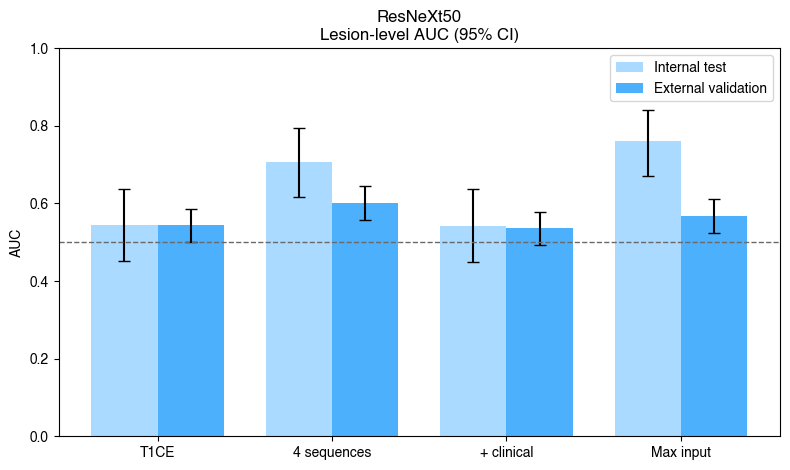

,arch,variant,internal_AUC,internal_Accuracy,internal_Precision,internal_Recall,internal_Specificity,internal_F1,internal_MCC,external_AUC,external_Accuracy,external_Precision,external_Recall,external_Specificity,external_F1,external_MCC
0,ResNeXt50,T1CE,"0.545 [0.452, 0.636]","0.548 [0.469, 0.628]","0.599 [0.508, 0.686]","0.738 [0.650, 0.826]","0.265 [0.161, 0.383]","0.661 [0.581, 0.734]","0.003 [-0.149, 0.163]","0.544 [0.500, 0.586]","0.494 [0.458, 0.531]","0.437 [0.392, 0.482]","0.759 [0.709, 0.806]","0.306 [0.263, 0.350]","0.553 [0.508, 0.595]","0.071 [-0.001, 0.144]"
1,ResNeXt50,4 sequences,"0.707 [0.616, 0.794]","0.637 [0.561, 0.713]","0.723 [0.623, 0.814]","0.638 [0.537, 0.736]","0.635 [0.508, 0.754]","0.678 [0.594, 0.754]","0.268 [0.110, 0.416]","0.602 [0.558, 0.644]","0.596 [0.559, 0.632]","0.517 [0.448, 0.587]","0.383 [0.324, 0.441]","0.746 [0.704, 0.787]","0.440 [0.380, 0.495]","0.138 [0.062, 0.215]"
2,ResNeXt50,+ clinical,"0.542 [0.448, 0.638]","0.586 [0.510, 0.662]","0.628 [0.535, 0.714]","0.755 [0.663, 0.842]","0.333 [0.218, 0.459]","0.686 [0.605, 0.756]","0.097 [-0.061, 0.259]","0.536 [0.494, 0.578]","0.526 [0.488, 0.563]","0.451 [0.403, 0.497]","0.652 [0.599, 0.705]","0.437 [0.388, 0.485]","0.533 [0.487, 0.575]","0.090 [0.013, 0.162]"
3,ResNeXt50,Max input,"0.761 [0.672, 0.841]","0.701 [0.624, 0.771]","0.797 [0.705, 0.882]","0.670 [0.570, 0.767]","0.746 [0.629, 0.852]","0.728 [0.644, 0.796]","0.408 [0.259, 0.546]","0.568 [0.524, 0.612]","0.571 [0.535, 0.609]","0.483 [0.423, 0.542]","0.500 [0.442, 0.560]","0.621 [0.573, 0.670]","0.491 [0.439, 0.543]","0.120 [0.048, 0.197]"


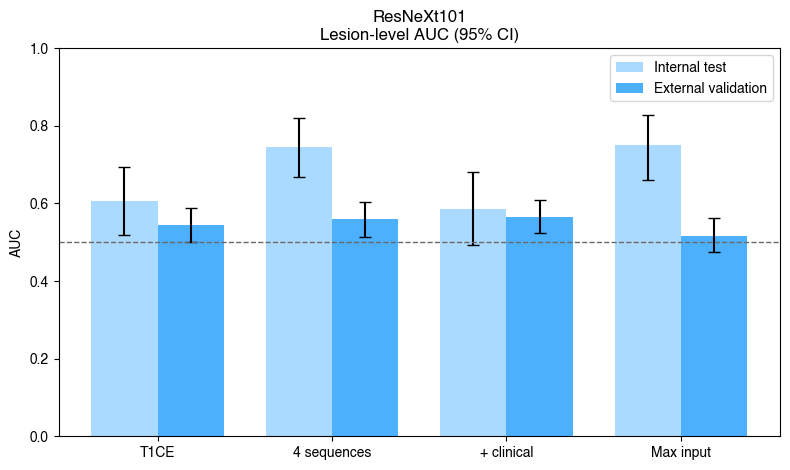

,arch,variant,internal_AUC,internal_Accuracy,internal_Precision,internal_Recall,internal_Specificity,internal_F1,internal_MCC,external_AUC,external_Accuracy,external_Precision,external_Recall,external_Specificity,external_F1,external_MCC
0,ResNeXt101,T1CE,"0.607 [0.518, 0.695]","0.569 [0.493, 0.648]","0.621 [0.525, 0.712]","0.713 [0.624, 0.802]","0.354 [0.239, 0.477]","0.661 [0.581, 0.732]","0.075 [-0.083, 0.233]","0.543 [0.501, 0.587]","0.499 [0.461, 0.536]","0.436 [0.391, 0.481]","0.723 [0.675, 0.773]","0.339 [0.295, 0.385]","0.542 [0.499, 0.583]","0.071 [-0.000, 0.143]"
1,ResNeXt101,4 sequences,"0.744 [0.668, 0.821]","0.707 [0.637, 0.771]","0.735 [0.643, 0.817]","0.798 [0.711, 0.874]","0.571 [0.444, 0.694]","0.765 [0.693, 0.824]","0.379 [0.227, 0.524]","0.559 [0.515, 0.604]","0.512 [0.473, 0.549]","0.444 [0.395, 0.490]","0.702 [0.647, 0.755]","0.377 [0.327, 0.426]","0.544 [0.497, 0.586]","0.082 [0.004, 0.154]"
2,ResNeXt101,+ clinical,"0.587 [0.493, 0.681]","0.618 [0.541, 0.694]","0.649 [0.559, 0.735]","0.787 [0.705, 0.867]","0.365 [0.250, 0.492]","0.712 [0.637, 0.776]","0.167 [0.013, 0.322]","0.566 [0.524, 0.608]","0.554 [0.518, 0.591]","0.472 [0.419, 0.520]","0.617 [0.558, 0.673]","0.510 [0.463, 0.559]","0.535 [0.488, 0.578]","0.126 [0.052, 0.197]"
3,ResNeXt101,Max input,"0.750 [0.659, 0.829]","0.682 [0.605, 0.752]","0.756 [0.662, 0.840]","0.691 [0.598, 0.782]","0.667 [0.549, 0.781]","0.722 [0.644, 0.791]","0.353 [0.199, 0.495]","0.517 [0.474, 0.563]","0.531 [0.494, 0.569]","0.446 [0.392, 0.500]","0.543 [0.485, 0.601]","0.523 [0.474, 0.574]","0.490 [0.441, 0.537]","0.064 [-0.010, 0.141]"


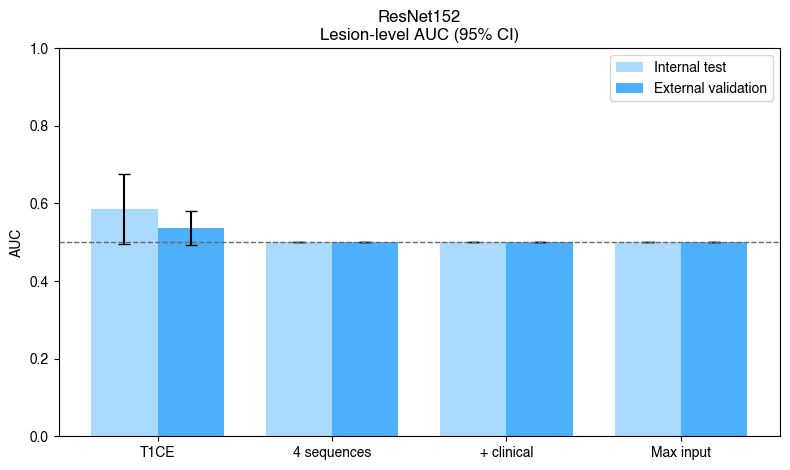

,arch,variant,internal_AUC,internal_Accuracy,internal_Precision,internal_Recall,internal_Specificity,internal_F1,internal_MCC,external_AUC,external_Accuracy,external_Precision,external_Recall,external_Specificity,external_F1,external_MCC
0,ResNet152,T1CE,"0.585 [0.495, 0.677]","0.577 [0.501, 0.656]","0.627 [0.532, 0.716]","0.730 [0.640, 0.821]","0.349 [0.234, 0.469]","0.675 [0.596, 0.745]","0.083 [-0.072, 0.242]","0.537 [0.494, 0.581]","0.512 [0.474, 0.548]","0.444 [0.399, 0.491]","0.700 [0.648, 0.752]","0.379 [0.331, 0.425]","0.543 [0.499, 0.586]","0.081 [0.007, 0.153]"
1,ResNet152,4 sequences,"0.500 [0.500, 0.500]","0.401 [0.331, 0.484]","0.000 [0.000, 0.000]","0.000 [0.000, 0.000]","1.000 [1.000, 1.000]","0.000 [0.000, 0.000]","0.000 [0.000, 0.000]","0.500 [0.500, 0.500]","0.585 [0.547, 0.622]","0.000 [0.000, 0.000]","0.000 [0.000, 0.000]","1.000 [1.000, 1.000]","0.000 [0.000, 0.000]","0.000 [0.000, 0.000]"
2,ResNet152,+ clinical,"0.500 [0.500, 0.500]","0.401 [0.331, 0.484]","0.000 [0.000, 0.000]","0.000 [0.000, 0.000]","1.000 [1.000, 1.000]","0.000 [0.000, 0.000]","0.000 [0.000, 0.000]","0.500 [0.500, 0.500]","0.585 [0.547, 0.622]","0.000 [0.000, 0.000]","0.000 [0.000, 0.000]","1.000 [1.000, 1.000]","0.000 [0.000, 0.000]","0.000 [0.000, 0.000]"
3,ResNet152,Max input,"0.500 [0.500, 0.500]","0.401 [0.331, 0.484]","0.000 [0.000, 0.000]","0.000 [0.000, 0.000]","1.000 [1.000, 1.000]","0.000 [0.000, 0.000]","0.000 [0.000, 0.000]","0.500 [0.500, 0.500]","0.585 [0.547, 0.622]","0.000 [0.000, 0.000]","0.000 [0.000, 0.000]","1.000 [1.000, 1.000]","0.000 [0.000, 0.000]","0.000 [0.000, 0.000]"


In [45]:
variant_order = ["t1c", "4 seq", "clinical", "max_info"]

variant_label_map = {
    "t1c": "T1CE",
    "4 seq": "4 sequences",
    "clinical": "+ clinical",
    "max_info": "Max input",
}

arch_order = ["ResNeXt50", "ResNeXt101", "ResNet152"]
# plot_grouped_auc_with_table(
#     df_ci=df_ll_ci,
#     archs=arch_order,
#     category_col="variant",
#     category_order=variant_order,
#     merge_archs=False,
#     category_label_map=variant_label_map,
#     per_panel_title_fmt="{arch}\nLesion-level AUC (95% CI)",
#     decimals=3,
# )

plot_grouped_auc_with_tables(
    df_ci=df_ll_ci,
    archs=arch_order,
    category_col="variant",
    category_order=variant_order,
    category_label_map=variant_label_map,
    merge_archs=False,
    table_mode="per_panel",
    per_panel_title_fmt="{arch}\nLesion-level AUC (95% CI)",
    decimals=3,
    include_numeric_cols=False,
)

### combined graphs

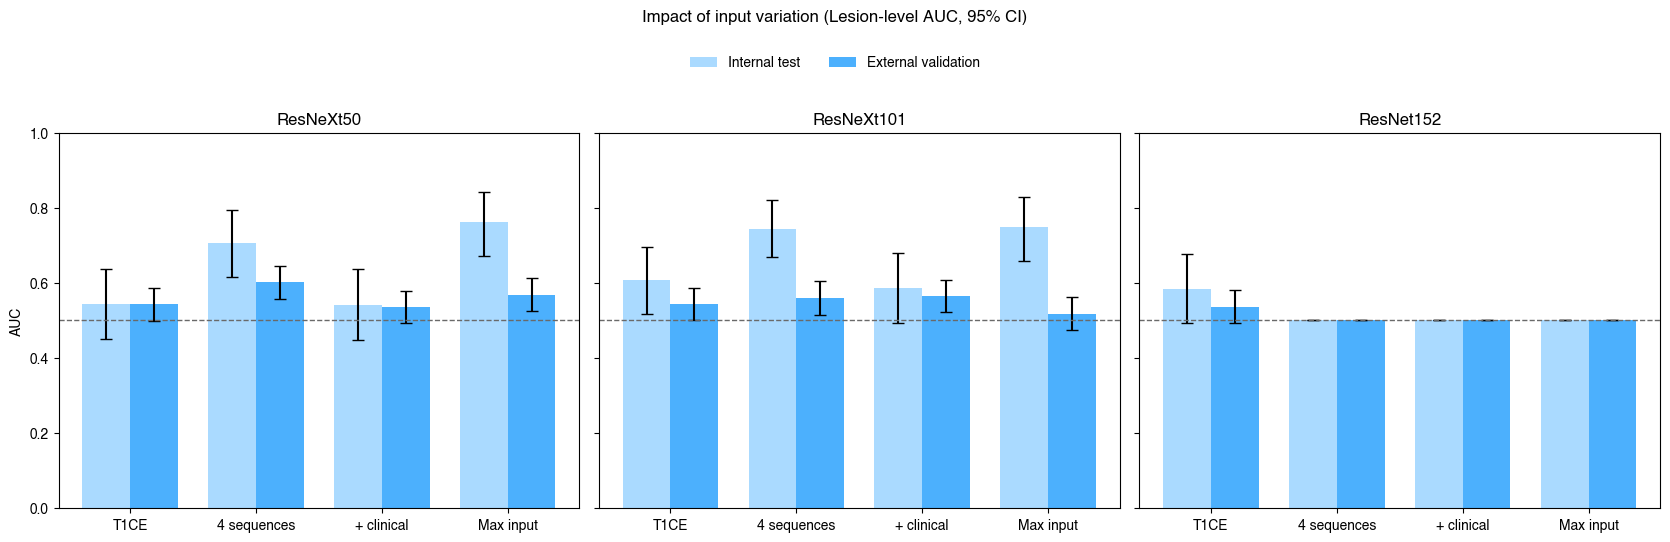

,arch,variant,internal_AUC,internal_Accuracy,internal_Precision,internal_Recall,internal_Specificity,internal_F1,internal_MCC,external_AUC,external_Accuracy,external_Precision,external_Recall,external_Specificity,external_F1,external_MCC
0,ResNeXt50,T1CE,"0.545 [0.452, 0.636]","0.548 [0.469, 0.628]","0.599 [0.508, 0.686]","0.738 [0.650, 0.826]","0.265 [0.161, 0.383]","0.661 [0.581, 0.734]","0.003 [-0.149, 0.163]","0.544 [0.500, 0.586]","0.494 [0.458, 0.531]","0.437 [0.392, 0.482]","0.759 [0.709, 0.806]","0.306 [0.263, 0.350]","0.553 [0.508, 0.595]","0.071 [-0.001, 0.144]"
1,ResNeXt50,4 sequences,"0.707 [0.616, 0.794]","0.637 [0.561, 0.713]","0.723 [0.623, 0.814]","0.638 [0.537, 0.736]","0.635 [0.508, 0.754]","0.678 [0.594, 0.754]","0.268 [0.110, 0.416]","0.602 [0.558, 0.644]","0.596 [0.559, 0.632]","0.517 [0.448, 0.587]","0.383 [0.324, 0.441]","0.746 [0.704, 0.787]","0.440 [0.380, 0.495]","0.138 [0.062, 0.215]"
2,ResNeXt50,+ clinical,"0.542 [0.448, 0.638]","0.586 [0.510, 0.662]","0.628 [0.535, 0.714]","0.755 [0.663, 0.842]","0.333 [0.218, 0.459]","0.686 [0.605, 0.756]","0.097 [-0.061, 0.259]","0.536 [0.494, 0.578]","0.526 [0.488, 0.563]","0.451 [0.403, 0.497]","0.652 [0.599, 0.705]","0.437 [0.388, 0.485]","0.533 [0.487, 0.575]","0.090 [0.013, 0.162]"
3,ResNeXt50,Max input,"0.761 [0.672, 0.841]","0.701 [0.624, 0.771]","0.797 [0.705, 0.882]","0.670 [0.570, 0.767]","0.746 [0.629, 0.852]","0.728 [0.644, 0.796]","0.408 [0.259, 0.546]","0.568 [0.524, 0.612]","0.571 [0.535, 0.609]","0.483 [0.423, 0.542]","0.500 [0.442, 0.560]","0.621 [0.573, 0.670]","0.491 [0.439, 0.543]","0.120 [0.048, 0.197]"
4,ResNeXt101,T1CE,"0.607 [0.518, 0.695]","0.569 [0.493, 0.648]","0.621 [0.525, 0.712]","0.713 [0.624, 0.802]","0.354 [0.239, 0.477]","0.661 [0.581, 0.732]","0.075 [-0.083, 0.233]","0.543 [0.501, 0.587]","0.499 [0.461, 0.536]","0.436 [0.391, 0.481]","0.723 [0.675, 0.773]","0.339 [0.295, 0.385]","0.542 [0.499, 0.583]","0.071 [-0.000, 0.143]"
5,ResNeXt101,4 sequences,"0.744 [0.668, 0.821]","0.707 [0.637, 0.771]","0.735 [0.643, 0.817]","0.798 [0.711, 0.874]","0.571 [0.444, 0.694]","0.765 [0.693, 0.824]","0.379 [0.227, 0.524]","0.559 [0.515, 0.604]","0.512 [0.473, 0.549]","0.444 [0.395, 0.490]","0.702 [0.647, 0.755]","0.377 [0.327, 0.426]","0.544 [0.497, 0.586]","0.082 [0.004, 0.154]"
6,ResNeXt101,+ clinical,"0.587 [0.493, 0.681]","0.618 [0.541, 0.694]","0.649 [0.559, 0.735]","0.787 [0.705, 0.867]","0.365 [0.250, 0.492]","0.712 [0.637, 0.776]","0.167 [0.013, 0.322]","0.566 [0.524, 0.608]","0.554 [0.518, 0.591]","0.472 [0.419, 0.520]","0.617 [0.558, 0.673]","0.510 [0.463, 0.559]","0.535 [0.488, 0.578]","0.126 [0.052, 0.197]"
7,ResNeXt101,Max input,"0.750 [0.659, 0.829]","0.682 [0.605, 0.752]","0.756 [0.662, 0.840]","0.691 [0.598, 0.782]","0.667 [0.549, 0.781]","0.722 [0.644, 0.791]","0.353 [0.199, 0.495]","0.517 [0.474, 0.563]","0.531 [0.494, 0.569]","0.446 [0.392, 0.500]","0.543 [0.485, 0.601]","0.523 [0.474, 0.574]","0.490 [0.441, 0.537]","0.064 [-0.010, 0.141]"
8,ResNet152,T1CE,"0.585 [0.495, 0.677]","0.577 [0.501, 0.656]","0.627 [0.532, 0.716]","0.730 [0.640, 0.821]","0.349 [0.234, 0.469]","0.675 [0.596, 0.745]","0.083 [-0.072, 0.242]","0.537 [0.494, 0.581]","0.512 [0.474, 0.548]","0.444 [0.399, 0.491]","0.700 [0.648, 0.752]","0.379 [0.331, 0.425]","0.543 [0.499, 0.586]","0.081 [0.007, 0.153]"
9,ResNet152,4 sequences,"0.500 [0.500, 0.500]","0.401 [0.331, 0.484]","0.000 [0.000, 0.000]","0.000 [0.000, 0.000]","1.000 [1.000, 1.000]","0.000 [0.000, 0.000]","0.000 [0.000, 0.000]","0.500 [0.500, 0.500]","0.585 [0.547, 0.622]","0.000 [0.000, 0.000]","0.000 [0.000, 0.000]","1.000 [1.000, 1.000]","0.000 [0.000, 0.000]","0.000 [0.000, 0.000]"


,arch,variant,internal_AUC,internal_Accuracy,internal_Precision,internal_Recall,internal_Specificity,internal_F1,internal_MCC,external_AUC,external_Accuracy,external_Precision,external_Recall,external_Specificity,external_F1,external_MCC
0,ResNeXt50,T1CE,"0.545 [0.452, 0.636]","0.548 [0.469, 0.628]","0.599 [0.508, 0.686]","0.738 [0.650, 0.826]","0.265 [0.161, 0.383]","0.661 [0.581, 0.734]","0.003 [-0.149, 0.163]","0.544 [0.500, 0.586]","0.494 [0.458, 0.531]","0.437 [0.392, 0.482]","0.759 [0.709, 0.806]","0.306 [0.263, 0.350]","0.553 [0.508, 0.595]","0.071 [-0.001, 0.144]"
1,ResNeXt50,4 sequences,"0.707 [0.616, 0.794]","0.637 [0.561, 0.713]","0.723 [0.623, 0.814]","0.638 [0.537, 0.736]","0.635 [0.508, 0.754]","0.678 [0.594, 0.754]","0.268 [0.110, 0.416]","0.602 [0.558, 0.644]","0.596 [0.559, 0.632]","0.517 [0.448, 0.587]","0.383 [0.324, 0.441]","0.746 [0.704, 0.787]","0.440 [0.380, 0.495]","0.138 [0.062, 0.215]"
2,ResNeXt50,+ clinical,"0.542 [0.448, 0.638]","0.586 [0.510, 0.662]","0.628 [0.535, 0.714]","0.755 [0.663, 0.842]","0.333 [0.218, 0.459]","0.686 [0.605, 0.756]","0.097 [-0.061, 0.259]","0.536 [0.494, 0.578]","0.526 [0.488, 0.563]","0.451 [0.403, 0.497]","0.652 [0.599, 0.705]","0.437 [0.388, 0.485]","0.533 [0.487, 0.575]","0.090 [0.013, 0.162]"
3,ResNeXt50,Max input,"0.761 [0.672, 0.841]","0.701 [0.624, 0.771]","0.797 [0.705, 0.882]","0.670 [0.570, 0.767]","0.746 [0.629, 0.852]","0.728 [0.644, 0.796]","0.408 [0.259, 0.546]","0.568 [0.524, 0.612]","0.571 [0.535, 0.609]","0.483 [0.423, 0.542]","0.500 [0.442, 0.560]","0.621 [0.573, 0.670]","0.491 [0.439, 0.543]","0.120 [0.048, 0.197]"
4,ResNeXt101,T1CE,"0.607 [0.518, 0.695]","0.569 [0.493, 0.648]","0.621 [0.525, 0.712]","0.713 [0.624, 0.802]","0.354 [0.239, 0.477]","0.661 [0.581, 0.732]","0.075 [-0.083, 0.233]","0.543 [0.501, 0.587]","0.499 [0.461, 0.536]","0.436 [0.391, 0.481]","0.723 [0.675, 0.773]","0.339 [0.295, 0.385]","0.542 [0.499, 0.583]","0.071 [-0.000, 0.143]"
5,ResNeXt101,4 sequences,"0.744 [0.668, 0.821]","0.707 [0.637, 0.771]","0.735 [0.643, 0.817]","0.798 [0.711, 0.874]","0.571 [0.444, 0.694]","0.765 [0.693, 0.824]","0.379 [0.227, 0.524]","0.559 [0.515, 0.604]","0.512 [0.473, 0.549]","0.444 [0.395, 0.490]","0.702 [0.647, 0.755]","0.377 [0.327, 0.426]","0.544 [0.497, 0.586]","0.082 [0.004, 0.154]"
6,ResNeXt101,+ clinical,"0.587 [0.493, 0.681]","0.618 [0.541, 0.694]","0.649 [0.559, 0.735]","0.787 [0.705, 0.867]","0.365 [0.250, 0.492]","0.712 [0.637, 0.776]","0.167 [0.013, 0.322]","0.566 [0.524, 0.608]","0.554 [0.518, 0.591]","0.472 [0.419, 0.520]","0.617 [0.558, 0.673]","0.510 [0.463, 0.559]","0.535 [0.488, 0.578]","0.126 [0.052, 0.197]"
7,ResNeXt101,Max input,"0.750 [0.659, 0.829]","0.682 [0.605, 0.752]","0.756 [0.662, 0.840]","0.691 [0.598, 0.782]","0.667 [0.549, 0.781]","0.722 [0.644, 0.791]","0.353 [0.199, 0.495]","0.517 [0.474, 0.563]","0.531 [0.494, 0.569]","0.446 [0.392, 0.500]","0.543 [0.485, 0.601]","0.523 [0.474, 0.574]","0.490 [0.441, 0.537]","0.064 [-0.010, 0.141]"
8,ResNet152,T1CE,"0.585 [0.495, 0.677]","0.577 [0.501, 0.656]","0.627 [0.532, 0.716]","0.730 [0.640, 0.821]","0.349 [0.234, 0.469]","0.675 [0.596, 0.745]","0.083 [-0.072, 0.242]","0.537 [0.494, 0.581]","0.512 [0.474, 0.548]","0.444 [0.399, 0.491]","0.700 [0.648, 0.752]","0.379 [0.331, 0.425]","0.543 [0.499, 0.586]","0.081 [0.007, 0.153]"
9,ResNet152,4 sequences,"0.500 [0.500, 0.500]","0.401 [0.331, 0.484]","0.000 [0.000, 0.000]","0.000 [0.000, 0.000]","1.000 [1.000, 1.000]","0.000 [0.000, 0.000]","0.000 [0.000, 0.000]","0.500 [0.500, 0.500]","0.585 [0.547, 0.622]","0.000 [0.000, 0.000]","0.000 [0.000, 0.000]","1.000 [1.000, 1.000]","0.000 [0.000, 0.000]","0.000 [0.000, 0.000]"


In [46]:
arch_order = ["ResNeXt50", "ResNeXt101", "ResNet152"]

# plot_grouped_auc_with_table(
#     df_ci=df_ll_ci,
#     archs=arch_order,
#     category_col="variant",
#     category_order=variant_order,
#     category_label_map=variant_label_map,
#     merge_archs=True,
#     table_mode="combined",  # or "per_panel" or "none"
#     suptitle="Impact of input variation (Lesion-level AUC, 95% CI)"
# )

plot_grouped_auc_with_tables(
    df_ci=df_ll_ci,
    archs=arch_order,
    category_col="variant",
    category_order=variant_order,
    category_label_map=variant_label_map,
    merge_archs=True,
    table_mode="combined",
    suptitle="Impact of input variation (Lesion-level AUC, 95% CI)",
    decimals=3,
    include_numeric_cols=False,
)

## Pretraining variation graphs
### separate graphs

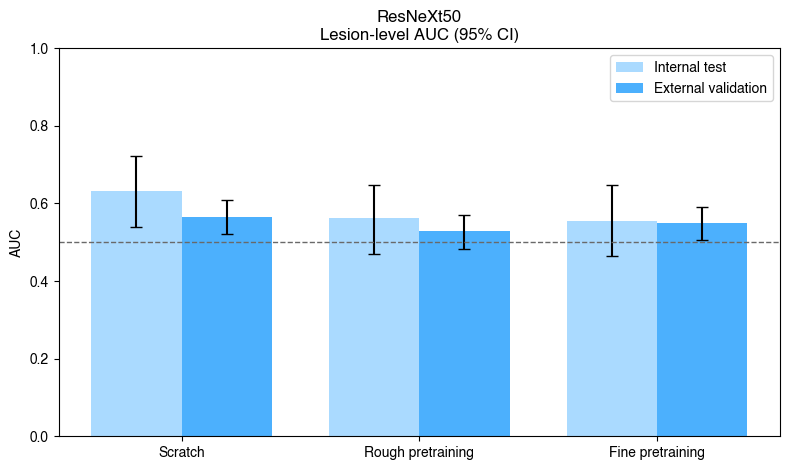

,arch,strategy,internal_AUC,internal_Accuracy,internal_Precision,internal_Recall,internal_Specificity,internal_F1,internal_MCC,external_AUC,external_Accuracy,external_Precision,external_Recall,external_Specificity,external_F1,external_MCC
0,ResNeXt50,Scratch,"0.632 [0.539, 0.722]","0.611 [0.535, 0.688]","0.684 [0.589, 0.772]","0.689 [0.592, 0.783]","0.496 [0.381, 0.612]","0.682 [0.599, 0.754]","0.183 [0.029, 0.334]","0.565 [0.522, 0.608]","0.550 [0.513, 0.587]","0.474 [0.419, 0.529]","0.583 [0.528, 0.637]","0.526 [0.480, 0.571]","0.509 [0.459, 0.557]","0.114 [0.040, 0.189]"
1,ResNeXt50,Rough pretraining,"0.562 [0.471, 0.648]","0.561 [0.478, 0.637]","0.603 [0.513, 0.686]","0.777 [0.691, 0.859]","0.238 [0.138, 0.354]","0.679 [0.600, 0.747]","0.017 [-0.137, 0.179]","0.528 [0.483, 0.570]","0.459 [0.423, 0.497]","0.422 [0.381, 0.465]","0.826 [0.782, 0.866]","0.198 [0.162, 0.238]","0.559 [0.516, 0.599]","0.031 [-0.040, 0.105]"
2,ResNeXt50,Fine pretraining,"0.554 [0.463, 0.648]","0.561 [0.484, 0.643]","0.609 [0.519, 0.695]","0.745 [0.660, 0.832]","0.286 [0.177, 0.409]","0.670 [0.592, 0.743]","0.034 [-0.115, 0.196]","0.549 [0.505, 0.591]","0.516 [0.479, 0.554]","0.443 [0.394, 0.491]","0.652 [0.595, 0.708]","0.420 [0.373, 0.469]","0.528 [0.480, 0.571]","0.073 [-0.001, 0.146]"


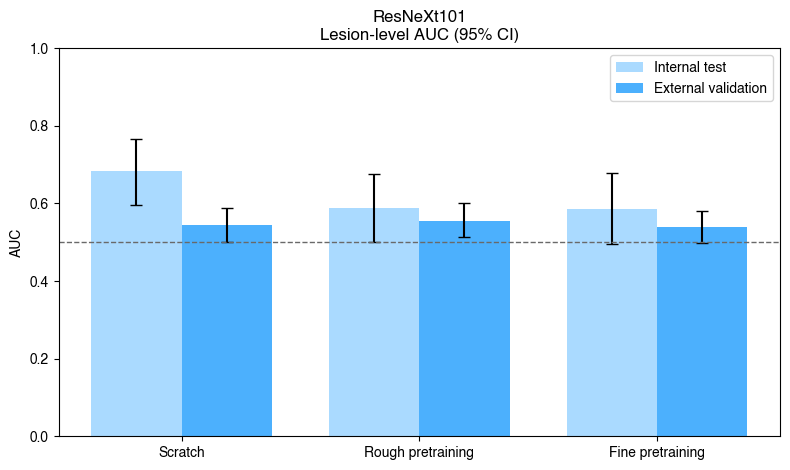

,arch,strategy,internal_AUC,internal_Accuracy,internal_Precision,internal_Recall,internal_Specificity,internal_F1,internal_MCC,external_AUC,external_Accuracy,external_Precision,external_Recall,external_Specificity,external_F1,external_MCC
0,ResNeXt101,Scratch,"0.682 [0.595, 0.765]","0.651 [0.576, 0.723]","0.694 [0.602, 0.777]","0.763 [0.676, 0.846]","0.484 [0.366, 0.604]","0.724 [0.649, 0.789]","0.255 [0.100, 0.404]","0.544 [0.501, 0.589]","0.522 [0.485, 0.560]","0.451 [0.402, 0.498]","0.681 [0.628, 0.732]","0.410 [0.363, 0.458]","0.538 [0.492, 0.581]","0.097 [0.022, 0.169]"
1,ResNeXt101,Rough pretraining,"0.588 [0.500, 0.676]","0.586 [0.510, 0.662]","0.622 [0.532, 0.706]","0.787 [0.705, 0.870]","0.286 [0.175, 0.406]","0.695 [0.622, 0.762]","0.083 [-0.073, 0.243]","0.556 [0.513, 0.602]","0.510 [0.474, 0.549]","0.443 [0.397, 0.490]","0.702 [0.652, 0.755]","0.374 [0.328, 0.422]","0.543 [0.499, 0.586]","0.079 [0.010, 0.153]"
2,ResNeXt101,Fine pretraining,"0.586 [0.494, 0.679]","0.522 [0.446, 0.605]","0.607 [0.500, 0.711]","0.574 [0.476, 0.674]","0.444 [0.322, 0.574]","0.590 [0.500, 0.670]","0.019 [-0.139, 0.183]","0.538 [0.497, 0.581]","0.493 [0.456, 0.529]","0.422 [0.375, 0.470]","0.606 [0.552, 0.663]","0.412 [0.365, 0.461]","0.498 [0.453, 0.541]","0.019 [-0.054, 0.093]"


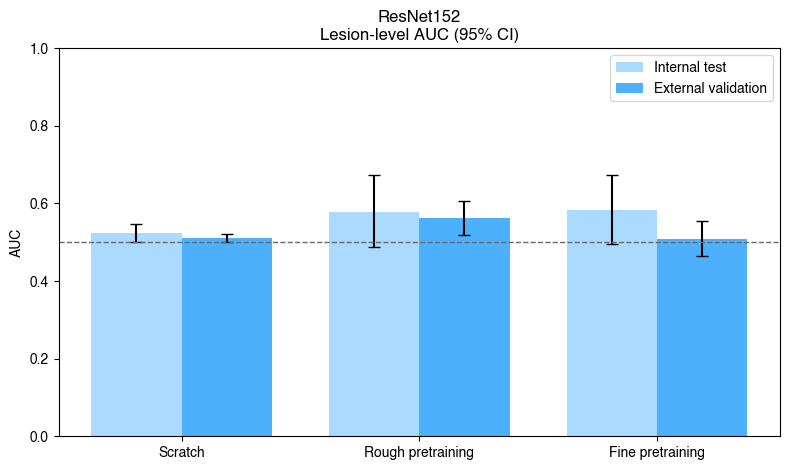

,arch,strategy,internal_AUC,internal_Accuracy,internal_Precision,internal_Recall,internal_Specificity,internal_F1,internal_MCC,external_AUC,external_Accuracy,external_Precision,external_Recall,external_Specificity,external_F1,external_MCC
0,ResNet152,Scratch,"0.523 [0.500, 0.546]","0.451 [0.379, 0.532]","0.161 [0.136, 0.183]","0.186 [0.164, 0.208]","0.845 [0.815, 0.875]","0.172 [0.153, 0.190]","0.033 [-0.007, 0.073]","0.510 [0.500, 0.521]","0.564 [0.526, 0.600]","0.109 [0.098, 0.120]","0.177 [0.164, 0.190]","0.837 [0.826, 0.849]","0.135 [0.124, 0.146]","0.015 [-0.003, 0.034]"
1,ResNet152,Rough pretraining,"0.579 [0.487, 0.672]","0.592 [0.516, 0.675]","0.644 [0.547, 0.735]","0.713 [0.621, 0.804]","0.413 [0.293, 0.540]","0.677 [0.597, 0.749]","0.130 [-0.024, 0.287]","0.562 [0.518, 0.605]","0.537 [0.497, 0.574]","0.460 [0.411, 0.510]","0.674 [0.621, 0.726]","0.440 [0.391, 0.486]","0.547 [0.502, 0.592]","0.114 [0.038, 0.186]"
2,ResNet152,Fine pretraining,"0.582 [0.494, 0.672]","0.541 [0.465, 0.618]","0.595 [0.504, 0.681]","0.734 [0.642, 0.825]","0.254 [0.149, 0.368]","0.657 [0.579, 0.727]","-0.013 [-0.164, 0.147]","0.509 [0.466, 0.555]","0.500 [0.463, 0.537]","0.437 [0.394, 0.482]","0.716 [0.667, 0.770]","0.347 [0.298, 0.392]","0.543 [0.501, 0.584]","0.067 [-0.007, 0.140]"


In [48]:
strategy_order = ["scratch", "rough", "fine"]

strategy_label_map = {
    "scratch": "Scratch",
    "rough": "Rough pretraining",
    "fine": "Fine pretraining",
}

# If you want to restrict pretraining comparison to T1c only (recommended if that's how you trained it):
# df_ci_t1c = df_ci[df_ci["variant"] == "t1c"].copy()
df_ll_ci_t1c = df_ll_ci  # keep as-is unless you want strict t1c-only comparison

arch_order = ["ResNeXt50", "ResNeXt101", "ResNet152"]
# plot_grouped_auc_with_table(
#     df_ci=df_ll_ci_t1c,
#     archs=arch_order,
#     category_col="strategy",
#     merge_archs=False,
#     category_order=strategy_order,
#     category_label_map=strategy_label_map,
#     per_panel_title_fmt="{arch}\nLesion-level AUC (95% CI)",
#     decimals=3,
# )

plot_grouped_auc_with_tables(
    df_ci=df_ll_ci,
    archs=arch_order,
    category_col="strategy",
    category_order=strategy_order,
    category_label_map=strategy_label_map,
    merge_archs=False,
    table_mode="per_panel",
    per_panel_title_fmt="{arch}\nLesion-level AUC (95% CI)",
    decimals=3,
    include_numeric_cols=False,
)

### combined graphs

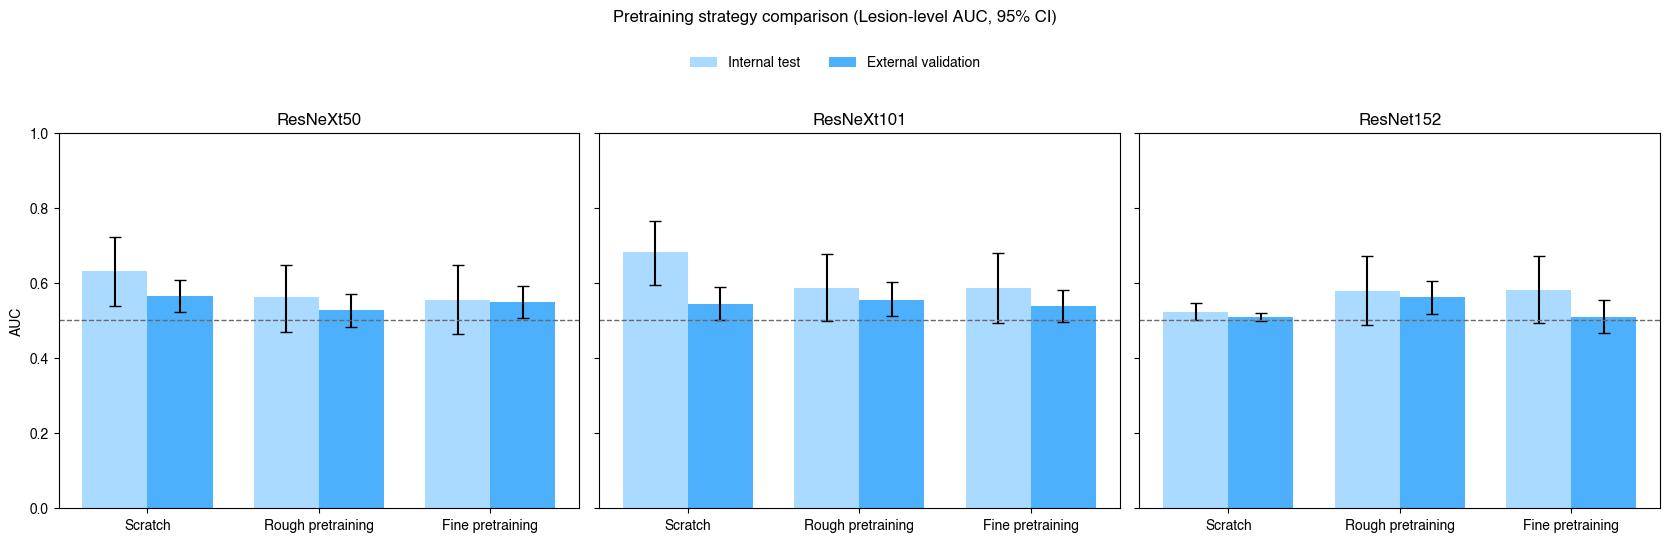

,arch,strategy,internal_AUC,internal_Accuracy,internal_Precision,internal_Recall,internal_Specificity,internal_F1,internal_MCC,external_AUC,external_Accuracy,external_Precision,external_Recall,external_Specificity,external_F1,external_MCC
0,ResNeXt50,Scratch,"0.632 [0.539, 0.722]","0.611 [0.535, 0.688]","0.684 [0.589, 0.772]","0.689 [0.592, 0.783]","0.496 [0.381, 0.612]","0.682 [0.599, 0.754]","0.183 [0.029, 0.334]","0.565 [0.522, 0.608]","0.550 [0.513, 0.587]","0.474 [0.419, 0.529]","0.583 [0.528, 0.637]","0.526 [0.480, 0.571]","0.509 [0.459, 0.557]","0.114 [0.040, 0.189]"
1,ResNeXt50,Rough pretraining,"0.562 [0.471, 0.648]","0.561 [0.478, 0.637]","0.603 [0.513, 0.686]","0.777 [0.691, 0.859]","0.238 [0.138, 0.354]","0.679 [0.600, 0.747]","0.017 [-0.137, 0.179]","0.528 [0.483, 0.570]","0.459 [0.423, 0.497]","0.422 [0.381, 0.465]","0.826 [0.782, 0.866]","0.198 [0.162, 0.238]","0.559 [0.516, 0.599]","0.031 [-0.040, 0.105]"
2,ResNeXt50,Fine pretraining,"0.554 [0.463, 0.648]","0.561 [0.484, 0.643]","0.609 [0.519, 0.695]","0.745 [0.660, 0.832]","0.286 [0.177, 0.409]","0.670 [0.592, 0.743]","0.034 [-0.115, 0.196]","0.549 [0.505, 0.591]","0.516 [0.479, 0.554]","0.443 [0.394, 0.491]","0.652 [0.595, 0.708]","0.420 [0.373, 0.469]","0.528 [0.480, 0.571]","0.073 [-0.001, 0.146]"
3,ResNeXt101,Scratch,"0.682 [0.595, 0.765]","0.651 [0.576, 0.723]","0.694 [0.602, 0.777]","0.763 [0.676, 0.846]","0.484 [0.366, 0.604]","0.724 [0.649, 0.789]","0.255 [0.100, 0.404]","0.544 [0.501, 0.589]","0.522 [0.485, 0.560]","0.451 [0.402, 0.498]","0.681 [0.628, 0.732]","0.410 [0.363, 0.458]","0.538 [0.492, 0.581]","0.097 [0.022, 0.169]"
4,ResNeXt101,Rough pretraining,"0.588 [0.500, 0.676]","0.586 [0.510, 0.662]","0.622 [0.532, 0.706]","0.787 [0.705, 0.870]","0.286 [0.175, 0.406]","0.695 [0.622, 0.762]","0.083 [-0.073, 0.243]","0.556 [0.513, 0.602]","0.510 [0.474, 0.549]","0.443 [0.397, 0.490]","0.702 [0.652, 0.755]","0.374 [0.328, 0.422]","0.543 [0.499, 0.586]","0.079 [0.010, 0.153]"
5,ResNeXt101,Fine pretraining,"0.586 [0.494, 0.679]","0.522 [0.446, 0.605]","0.607 [0.500, 0.711]","0.574 [0.476, 0.674]","0.444 [0.322, 0.574]","0.590 [0.500, 0.670]","0.019 [-0.139, 0.183]","0.538 [0.497, 0.581]","0.493 [0.456, 0.529]","0.422 [0.375, 0.470]","0.606 [0.552, 0.663]","0.412 [0.365, 0.461]","0.498 [0.453, 0.541]","0.019 [-0.054, 0.093]"
6,ResNet152,Scratch,"0.523 [0.500, 0.546]","0.451 [0.379, 0.532]","0.161 [0.136, 0.183]","0.186 [0.164, 0.208]","0.845 [0.815, 0.875]","0.172 [0.153, 0.190]","0.033 [-0.007, 0.073]","0.510 [0.500, 0.521]","0.564 [0.526, 0.600]","0.109 [0.098, 0.120]","0.177 [0.164, 0.190]","0.837 [0.826, 0.849]","0.135 [0.124, 0.146]","0.015 [-0.003, 0.034]"
7,ResNet152,Rough pretraining,"0.579 [0.487, 0.672]","0.592 [0.516, 0.675]","0.644 [0.547, 0.735]","0.713 [0.621, 0.804]","0.413 [0.293, 0.540]","0.677 [0.597, 0.749]","0.130 [-0.024, 0.287]","0.562 [0.518, 0.605]","0.537 [0.497, 0.574]","0.460 [0.411, 0.510]","0.674 [0.621, 0.726]","0.440 [0.391, 0.486]","0.547 [0.502, 0.592]","0.114 [0.038, 0.186]"
8,ResNet152,Fine pretraining,"0.582 [0.494, 0.672]","0.541 [0.465, 0.618]","0.595 [0.504, 0.681]","0.734 [0.642, 0.825]","0.254 [0.149, 0.368]","0.657 [0.579, 0.727]","-0.013 [-0.164, 0.147]","0.509 [0.466, 0.555]","0.500 [0.463, 0.537]","0.437 [0.394, 0.482]","0.716 [0.667, 0.770]","0.347 [0.298, 0.392]","0.543 [0.501, 0.584]","0.067 [-0.007, 0.140]"


,arch,strategy,internal_AUC,internal_Accuracy,internal_Precision,internal_Recall,internal_Specificity,internal_F1,internal_MCC,external_AUC,external_Accuracy,external_Precision,external_Recall,external_Specificity,external_F1,external_MCC
0,ResNeXt50,Scratch,"0.632 [0.539, 0.722]","0.611 [0.535, 0.688]","0.684 [0.589, 0.772]","0.689 [0.592, 0.783]","0.496 [0.381, 0.612]","0.682 [0.599, 0.754]","0.183 [0.029, 0.334]","0.565 [0.522, 0.608]","0.550 [0.513, 0.587]","0.474 [0.419, 0.529]","0.583 [0.528, 0.637]","0.526 [0.480, 0.571]","0.509 [0.459, 0.557]","0.114 [0.040, 0.189]"
1,ResNeXt50,Rough pretraining,"0.562 [0.471, 0.648]","0.561 [0.478, 0.637]","0.603 [0.513, 0.686]","0.777 [0.691, 0.859]","0.238 [0.138, 0.354]","0.679 [0.600, 0.747]","0.017 [-0.137, 0.179]","0.528 [0.483, 0.570]","0.459 [0.423, 0.497]","0.422 [0.381, 0.465]","0.826 [0.782, 0.866]","0.198 [0.162, 0.238]","0.559 [0.516, 0.599]","0.031 [-0.040, 0.105]"
2,ResNeXt50,Fine pretraining,"0.554 [0.463, 0.648]","0.561 [0.484, 0.643]","0.609 [0.519, 0.695]","0.745 [0.660, 0.832]","0.286 [0.177, 0.409]","0.670 [0.592, 0.743]","0.034 [-0.115, 0.196]","0.549 [0.505, 0.591]","0.516 [0.479, 0.554]","0.443 [0.394, 0.491]","0.652 [0.595, 0.708]","0.420 [0.373, 0.469]","0.528 [0.480, 0.571]","0.073 [-0.001, 0.146]"
3,ResNeXt101,Scratch,"0.682 [0.595, 0.765]","0.651 [0.576, 0.723]","0.694 [0.602, 0.777]","0.763 [0.676, 0.846]","0.484 [0.366, 0.604]","0.724 [0.649, 0.789]","0.255 [0.100, 0.404]","0.544 [0.501, 0.589]","0.522 [0.485, 0.560]","0.451 [0.402, 0.498]","0.681 [0.628, 0.732]","0.410 [0.363, 0.458]","0.538 [0.492, 0.581]","0.097 [0.022, 0.169]"
4,ResNeXt101,Rough pretraining,"0.588 [0.500, 0.676]","0.586 [0.510, 0.662]","0.622 [0.532, 0.706]","0.787 [0.705, 0.870]","0.286 [0.175, 0.406]","0.695 [0.622, 0.762]","0.083 [-0.073, 0.243]","0.556 [0.513, 0.602]","0.510 [0.474, 0.549]","0.443 [0.397, 0.490]","0.702 [0.652, 0.755]","0.374 [0.328, 0.422]","0.543 [0.499, 0.586]","0.079 [0.010, 0.153]"
5,ResNeXt101,Fine pretraining,"0.586 [0.494, 0.679]","0.522 [0.446, 0.605]","0.607 [0.500, 0.711]","0.574 [0.476, 0.674]","0.444 [0.322, 0.574]","0.590 [0.500, 0.670]","0.019 [-0.139, 0.183]","0.538 [0.497, 0.581]","0.493 [0.456, 0.529]","0.422 [0.375, 0.470]","0.606 [0.552, 0.663]","0.412 [0.365, 0.461]","0.498 [0.453, 0.541]","0.019 [-0.054, 0.093]"
6,ResNet152,Scratch,"0.523 [0.500, 0.546]","0.451 [0.379, 0.532]","0.161 [0.136, 0.183]","0.186 [0.164, 0.208]","0.845 [0.815, 0.875]","0.172 [0.153, 0.190]","0.033 [-0.007, 0.073]","0.510 [0.500, 0.521]","0.564 [0.526, 0.600]","0.109 [0.098, 0.120]","0.177 [0.164, 0.190]","0.837 [0.826, 0.849]","0.135 [0.124, 0.146]","0.015 [-0.003, 0.034]"
7,ResNet152,Rough pretraining,"0.579 [0.487, 0.672]","0.592 [0.516, 0.675]","0.644 [0.547, 0.735]","0.713 [0.621, 0.804]","0.413 [0.293, 0.540]","0.677 [0.597, 0.749]","0.130 [-0.024, 0.287]","0.562 [0.518, 0.605]","0.537 [0.497, 0.574]","0.460 [0.411, 0.510]","0.674 [0.621, 0.726]","0.440 [0.391, 0.486]","0.547 [0.502, 0.592]","0.114 [0.038, 0.186]"
8,ResNet152,Fine pretraining,"0.582 [0.494, 0.672]","0.541 [0.465, 0.618]","0.595 [0.504, 0.681]","0.734 [0.642, 0.825]","0.254 [0.149, 0.368]","0.657 [0.579, 0.727]","-0.013 [-0.164, 0.147]","0.509 [0.466, 0.555]","0.500 [0.463, 0.537]","0.437 [0.394, 0.482]","0.716 [0.667, 0.770]","0.347 [0.298, 0.392]","0.543 [0.501, 0.584]","0.067 [-0.007, 0.140]"


In [49]:
strategy_order = ["scratch", "rough", "fine"]
strategy_label_map = {
    "scratch": "Scratch",
    "rough": "Rough pretraining",
    "fine": "Fine pretraining",
}

# plot_grouped_auc_with_table(
#     df_ci=df_ll_ci_t1c,
#     archs=arch_order,
#     category_col="strategy",
#     category_order=strategy_order,
#     category_label_map=strategy_label_map,
#     merge_archs=True,
#     table_mode="combined",
#     suptitle="Pretraining strategy comparison (Lesion-level AUC, 95% CI)"
# )

plot_grouped_auc_with_tables(
    df_ci=df_ll_ci,
    archs=arch_order,
    category_col="strategy",
    category_order=strategy_order,
    category_label_map=strategy_label_map,
    merge_archs=True,
    table_mode="combined",
    suptitle="Pretraining strategy comparison (Lesion-level AUC, 95% CI)",
    decimals=3,
    include_numeric_cols=False,
)

## Comparison Internal and External Validation

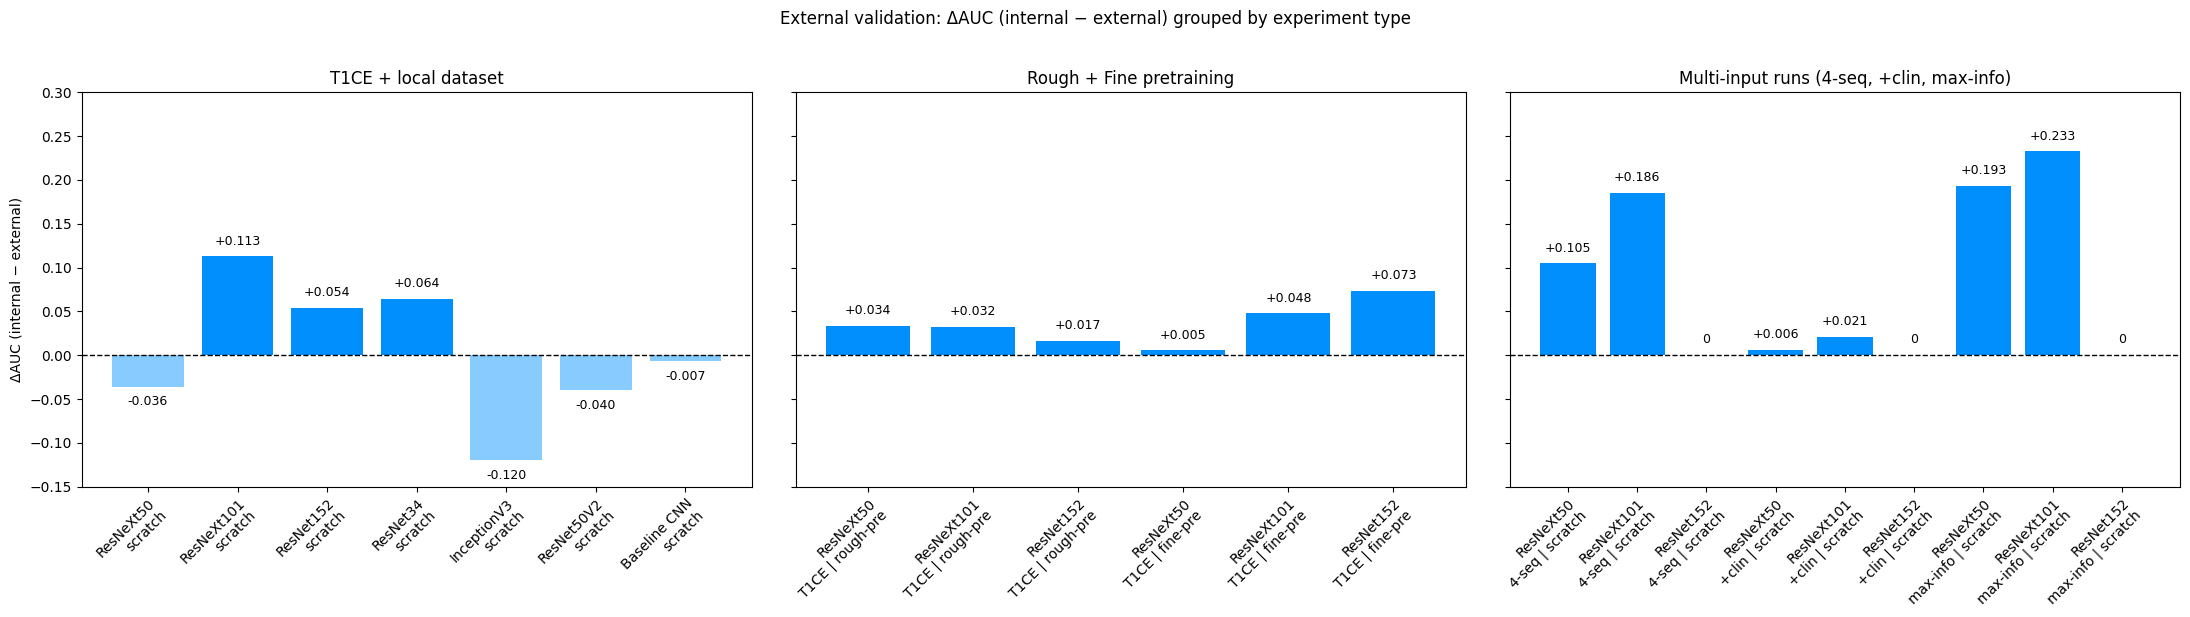

,Architecture,Input,Pretraining,Internal AUC (95% CI),External AUC (95% CI),ΔAUC (int−ext),Run ID
0,ResNeXt50,T1CE,scratch,"0.518 [0.421, 0.614]","0.554 [0.511, 0.597]",-0.036,t1c_scratch_resnext50_lesion_23_02_2026
1,ResNeXt101,T1CE,scratch,"0.648 [0.561, 0.730]","0.536 [0.493, 0.579]",+0.113,t1c_scratch_resnext101_lesion_23_02_2026
2,ResNet152,T1CE,scratch,"0.594 [0.502, 0.685]","0.540 [0.498, 0.582]",+0.054,t1c_scratch_resnet152_lesion_23_02_2026
3,ResNet34,T1CE,scratch,"0.554 [0.461, 0.650]","0.490 [0.447, 0.534]",+0.064,t1c_scratch_resnet34_lesion_23_02_2026
4,InceptionV3,T1CE,scratch,"0.440 [0.349, 0.539]","0.560 [0.515, 0.605]",-0.120,t1c_scratch_inceptionv3_lesion_23_02_2026
5,ResNet50V2,T1CE,scratch,"0.549 [0.454, 0.640]","0.589 [0.544, 0.630]",-0.040,t1c_scratch_resnet50v2_lesion_23_02_2026
6,Baseline CNN,T1CE,scratch,"0.496 [0.410, 0.590]","0.503 [0.459, 0.547]",-0.007,t1c_scratch_base_conv_lesion_23_02_2026
7,ResNeXt50,T1CE,rough-pre,"0.562 [0.471, 0.648]","0.528 [0.483, 0.570]",+0.034,t1c_rough_resnext50_lesion_23_02_2026
8,ResNeXt101,T1CE,rough-pre,"0.588 [0.500, 0.676]","0.556 [0.513, 0.602]",+0.032,t1c_rough_resnext101_lesion_23_02_2026
9,ResNet152,T1CE,rough-pre,"0.579 [0.487, 0.672]","0.562 [0.518, 0.605]",+0.017,t1c_rough_resnet152_lesion_23_02_2026


In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

# ============================================================
# BAR PLOT: ΔAUC (internal − external) with 0 reference line
# + Option to annotate exact Δ values on bars
# + Paper-ready table (internal/external AUC with CI + ΔAUC)
# ============================================================

# -----------------------------
# USER OPTIONS
# -----------------------------
SHOW_DELTA_TEXT_ON_BARS = True   # <- set False to hide numbers on bars
DELTA_TEXT_DECIMALS = 3
Y_LIM = (-0.15, 0.3)              # <- adjust as needed, or set None for auto
SORT_MODE = "by_arch"            # "by_arch" or "by_delta"

path_to_evals_patient_level = Path(
    "/Users/LennartPhilipp/Desktop/Uni/Prowiss/Training/Evaluations/eval_internal_external_lesion_level_23_02_26"
)

runs = [f for f in path_to_evals_patient_level.iterdir()
        if f.is_dir() and f.name.startswith("lung_vs_nolung")]
runs_dict = {r.name.removeprefix("lung_vs_nolung_2cls_"): r for r in runs}

# -----------------------------
# Helpers (parsing + formatting)
# -----------------------------
def parse_strategy(run: str):
    r = run.lower()
    if re.search(r"(^|_)scratch(_|$)", r): return "scratch"
    if re.search(r"(^|_)rough(_|$)", r):   return "rough"
    if re.search(r"(^|_)fine(_|$)", r):    return "fine"
    return "unknown"

def parse_arch(run: str):
    r = run.lower()
    if "resnext101" in r: return "ResNeXt101"
    if "resnext50" in r:  return "ResNeXt50"
    if "resnet152" in r:  return "ResNet152"
    if "resnet34" in r:   return "ResNet34"
    if "inception" in r:  return "InceptionV3"
    if "resnet50v2" in r: return "ResNet50V2"
    if "base_conv" in r: return "Baseline CNN"
    return "Other"

def parse_input_variant(run: str):
    r = run.lower()
    if r.startswith("4seq"):     return "4 seq"
    if r.startswith("t1c_clin"): return "clinical"
    if r.startswith("maxinfo"):  return "max_info"
    if r.startswith("t1c"):      return "t1c"
    return "unknown"

def format_auc_ci(val, lo, hi, decimals=3):
    if pd.isna(val):
        return ""
    if pd.isna(lo) or pd.isna(hi):
        return f"{val:.{decimals}f}"
    return f"{val:.{decimals}f} [{lo:.{decimals}f}, {hi:.{decimals}f}]"

# -----------------------------
# Build per-run wide table from df_ci
# df_ci must have: run, split, auc, auc_ci_low, auc_ci_high
# -----------------------------

rows = []

for run, run_path in runs_dict.items():
    arch = parse_arch(run)
    variant = parse_input_variant(run)
    strategy = parse_strategy(run)

    for split in ["internal", "external"]:
        json_path = run_path / f"{split}_ensemble_lesion.json"
        if not json_path.exists():
            continue

        met = json.loads(json_path.read_text())

        rows.append({
            "run": run,
            "arch": arch,
            "variant": variant,
            "strategy": strategy,
            "split": split,
            "auc": met.get("auc", np.nan),
            "auc_ci_low": met.get("auc_ci_low", np.nan),
            "auc_ci_high": met.get("auc_ci_high", np.nan),
        })

df_ci = pd.DataFrame(rows)



wide = df_ci.pivot_table(
    index=["run"],
    columns="split",
    values=["auc", "auc_ci_low", "auc_ci_high"],
    aggfunc="first"
)
wide.columns = [f"{a}_{b}" for a, b in wide.columns]  # e.g., auc_internal
wide = wide.reset_index()

# add labels from run name
wide["arch"] = wide["run"].apply(parse_arch)
wide["variant"] = wide["run"].apply(parse_input_variant)
wide["strategy"] = wide["run"].apply(parse_strategy)

# delta (positive = worse externally)
wide["delta_auc"] = wide["auc_internal"] - wide["auc_external"]

# Create a readable label for the x-axis (short but informative)
variant_map = {"t1c": "T1CE", "4 seq": "4-seq", "clinical": "+clin", "max_info": "max-info", "unknown": "unknown"}
strategy_map = {"scratch": "scratch", "rough": "rough-pre", "fine": "fine-pre", "unknown": "unknown"}

wide["x_label"] = wide.apply(
    lambda r: f"{r['arch']}\n{variant_map.get(r['variant'], r['variant'])} | {strategy_map.get(r['strategy'], r['strategy'])}",
    axis=1
)

# -----------------------------
# Sorting
# -----------------------------
if SORT_MODE == "by_delta":
    wide = wide.sort_values("delta_auc", ascending=False).reset_index(drop=True)
else:
    arch_order = {
        "ResNeXt101": 0, "ResNeXt50": 1, "ResNet152": 2, "ResNet34": 3,
        "InceptionV3": 4, "ResNet50V2": 5, "CustomCNN": 6, "Other": 99
    }
    variant_order = {"t1c": 0, "4 seq": 1, "clinical": 2, "max_info": 3, "unknown": 9}
    strategy_order = {"scratch": 0, "rough": 1, "fine": 2, "unknown": 9}
    wide["arch_rank"] = wide["arch"].map(lambda x: arch_order.get(x, 99))
    wide["variant_rank"] = wide["variant"].map(lambda x: variant_order.get(x, 9))
    wide["strategy_rank"] = wide["strategy"].map(lambda x: strategy_order.get(x, 9))
    wide = wide.sort_values(["arch_rank", "variant_rank", "strategy_rank", "run"]).reset_index(drop=True)

# -----------------------------
# Custom grouping order:
#   1) Input variant grouped together
#   2) Pretraining grouped together
#   3) Architecture order within groups
#   4) Stable tie-breaker by run
# -----------------------------

# Desired group orders
variant_order = {
    "t1c": 0,
    "4 seq": 1,
    "clinical": 2,
    "max_info": 3,
    "unknown": 9
}
strategy_order = {
    "scratch": 0,
    "rough": 1,
    "fine": 2,
    "unknown": 9
}
arch_order = {
    "ResNeXt50": 0,
    "ResNeXt101": 1,
    "ResNet152": 2,
    "ResNet34": 3,
    "InceptionV3": 4,
    "ResNet50V2": 5,
    "Baseline CNN": 6,
    "Other": 99
}

# Make sure these columns exist (from your parsing)
# wide["variant"], wide["strategy"], wide["arch"]

wide["variant_rank"] = wide["variant"].map(lambda x: variant_order.get(x, 9))
wide["strategy_rank"] = wide["strategy"].map(lambda x: strategy_order.get(x, 9))
wide["arch_rank"] = wide["arch"].map(lambda x: arch_order.get(x, 99))

# Option A (most common): group by INPUT first, then PRETRAINING
wide = wide.sort_values(
    ["variant_rank", "strategy_rank", "arch_rank", "run"],
    ascending=[True, True, True, True]
).reset_index(drop=True)

# If you prefer grouping by PRETRAINING first, then INPUT, use this instead:
# wide = wide.sort_values(
#     ["strategy_rank", "variant_rank", "arch_rank", "run"],
#     ascending=[True, True, True, True]
# ).reset_index(drop=True)

# # -----------------------------
# # BAR PLOT (ΔAUC) with 0-line
# # -----------------------------
# x = np.arange(len(wide))
# delta = wide["delta_auc"].values

# fig_w = max(12, 0.28 * len(wide) + 6)
# fig, ax = plt.subplots(figsize=(fig_w, 6))

# # Color bars depending on sign
# colors = [LIGHT_BLUE if v < 0 else DARK_BLUE for v in delta]
# bars = ax.bar(x, delta, color=colors)

# # 0 reference line
# ax.axhline(0.0, linestyle="--", linewidth=1, color="black")

# ax.set_ylabel("ΔAUC (internal − external)")
# ax.set_title("External validation: AUC difference per run (bars above/below 0)")

# # Rotate x-axis labels by 45 degrees
# ax.set_xticks(x)
# ax.set_xticklabels(
#     wide["x_label"].tolist(),
#     rotation=45,
#     ha="right",
#     rotation_mode="anchor"
# )

# if Y_LIM is not None:
#     ax.set_ylim(Y_LIM)
# else:
#     lo = np.nanmin(delta)
#     hi = np.nanmax(delta)
#     pad = 0.05
#     ax.set_ylim(lo - pad, hi + pad)

# # Optional: show exact delta on bars
# if SHOW_DELTA_TEXT_ON_BARS:
#     for rect, val in zip(bars, delta):
#         if not np.isfinite(val):
#             continue

#         # Format value: show "0" instead of "+0.000"
#         if np.isclose(val, 0.0, atol=1e-6):
#             label = "0"
#         else:
#             label = f"{val:+.{DELTA_TEXT_DECIMALS}f}"

#         y = rect.get_height()
#         va = "bottom" if y >= 0 else "top"
#         offset = 0.01 if y >= 0 else -0.01

#         ax.text(
#             rect.get_x() + rect.get_width()/2,
#             y + offset,
#             label,
#             ha="center",
#             va=va,
#             fontsize=9
#         )

# plt.tight_layout()
# plt.show()

# ============================================================
# 1x3 MULTI-PANEL VERSION (custom grouping)
#   Panel 1: all T1CE runs
#   Panel 2: rough + fine pretraining runs (all variants)
#   Panel 3: 4-seq + +clin + max-info runs
#
# Plot shows ΔAUC (internal − external), 0-line, sign-based color,
# optional value labels, and less crowded x-labels.
# ============================================================

import numpy as np
import matplotlib.pyplot as plt

# ---- fallback colors if you haven't defined LIGHT_BLUE / DARK_BLUE elsewhere ----
try:
    _ = LIGHT_BLUE
    _ = DARK_BLUE
except NameError:
    LIGHT_BLUE = "#8ecae6"   # light blue
    DARK_BLUE  = "#219ebc"   # darker blue

# -----------------------------
# USER OPTIONS (reuse yours)
# -----------------------------
SHOW_DELTA_TEXT_ON_BARS = True
DELTA_TEXT_DECIMALS = 3
Y_LIM = (-0.15, 0.30)  # shared y-limits across panels (recommended)

# -----------------------------
# Ensure helper maps exist (you already have these)
# -----------------------------
variant_map = {"t1c": "T1CE", "4 seq": "4-seq", "clinical": "+clin", "max_info": "max-info", "unknown": "unknown"}
strategy_map = {"scratch": "scratch", "rough": "rough-pre", "fine": "fine-pre", "unknown": "unknown"}

# Ranking for consistent ordering inside panels
variant_rank_map = {"t1c": 0, "4 seq": 1, "clinical": 2, "max_info": 3, "unknown": 9}
strategy_rank_map = {"scratch": 0, "rough": 1, "fine": 2, "unknown": 9}
arch_rank_map = arch_order  # from your code (ResNeXt50->..., etc.)

plot_df = wide.copy()
plot_df["variant_rank"] = plot_df["variant"].map(lambda x: variant_rank_map.get(x, 9))
plot_df["strategy_rank"] = plot_df["strategy"].map(lambda x: strategy_rank_map.get(x, 9))
plot_df["arch_rank"] = plot_df["arch"].map(lambda x: arch_rank_map.get(x, 99))

# Less crowded x-labels:
# (include variant only when a panel mixes variants)
def make_label(row, include_variant: bool):
    arch = row["arch"]
    strat = strategy_map.get(row["strategy"], row["strategy"])
    if include_variant:
        var = variant_map.get(row["variant"], row["variant"])
        return f"{arch}\n{var} | {strat}"
    return f"{arch}\n{strat}"

# -----------------------------
# Define the 3 panels as filters
# -----------------------------
panels = [
    {
        "title": "T1CE + local dataset",
        "mask": (plot_df["variant"] == "t1c") & (plot_df["strategy"] == "scratch"),
        "include_variant_in_label": False,
        "sort_cols": ["strategy_rank", "arch_rank", "run"],
    },
    {
        "title": "Rough + Fine pretraining",
        "mask": (plot_df["strategy"].isin(["rough", "fine"])),
        "include_variant_in_label": True,
        "sort_cols": ["variant_rank", "strategy_rank", "arch_rank", "run"],
    },
    {
        "title": "Multi-input runs (4-seq, +clin, max-info)",
        "mask": (plot_df["variant"].isin(["4 seq", "clinical", "max_info"])),
        "include_variant_in_label": True,
        "sort_cols": ["variant_rank", "strategy_rank", "arch_rank", "run"],
    },
]

# -----------------------------
# Create 1x3 plot
# -----------------------------
fig, axes = plt.subplots(1, 3, figsize=(22, 6), sharey=True)

for ax, p in zip(axes, panels):
    sub = plot_df.loc[p["mask"]].copy()
    sub = sub.sort_values(p["sort_cols"]).reset_index(drop=True)

    if sub.empty:
        ax.set_title(p["title"] + " (no runs)")
        ax.axhline(0.0, linestyle="--", linewidth=1, color="black")
        if Y_LIM is not None:
            ax.set_ylim(Y_LIM)
        ax.set_xticks([])
        continue

    sub["panel_label"] = sub.apply(lambda r: make_label(r, p["include_variant_in_label"]), axis=1)

    x = np.arange(len(sub))
    delta = sub["delta_auc"].values

    colors = [LIGHT_BLUE if val < 0 else DARK_BLUE for val in delta]
    bars = ax.bar(x, delta, color=colors)

    ax.axhline(0.0, linestyle="--", linewidth=1, color="black")
    ax.set_title(p["title"])
    ax.set_xticks(x)
    ax.set_xticklabels(sub["panel_label"].tolist(), rotation=45, ha="right", rotation_mode="anchor")

    if Y_LIM is not None:
        ax.set_ylim(Y_LIM)

    if SHOW_DELTA_TEXT_ON_BARS:
        for rect, val in zip(bars, delta):
            if not np.isfinite(val):
                continue
            if np.isclose(val, 0.0, atol=1e-6):
                label = "0"
            else:
                label = f"{val:+.{DELTA_TEXT_DECIMALS}f}"

            y = rect.get_height()
            va = "bottom" if y >= 0 else "top"
            offset = 0.01 if y >= 0 else -0.01

            ax.text(
                rect.get_x() + rect.get_width() / 2,
                y + offset,
                label,
                ha="center",
                va=va,
                fontsize=9
            )

# Common y-label + title
fig.suptitle("External validation: ΔAUC (internal − external) grouped by experiment type", y=1.02)
axes[0].set_ylabel("ΔAUC (internal − external)")

plt.tight_layout()
plt.show()

# -----------------------------
# PAPER-READY TABLE
# (exportable to CSV/Excel/LaTeX)
# -----------------------------
paper_table = pd.DataFrame({
    "Architecture": wide["arch"],
    "Input": wide["variant"].map(lambda x: variant_map.get(x, x)),
    "Pretraining": wide["strategy"].map(lambda x: strategy_map.get(x, x)),
    "Internal AUC (95% CI)": wide.apply(lambda r: format_auc_ci(r.get("auc_internal"), r.get("auc_ci_low_internal"), r.get("auc_ci_high_internal")), axis=1),
    "External AUC (95% CI)": wide.apply(lambda r: format_auc_ci(r.get("auc_external"), r.get("auc_ci_low_external"), r.get("auc_ci_high_external")), axis=1),
    "ΔAUC (int−ext)": wide["delta_auc"].map(lambda v: "" if pd.isna(v) else f"{v:+.3f}"),
    "Run ID": wide["run"],  # keep for traceability; drop for the manuscript if you want
})

# Preview
paper_table

# Export (uncomment what you want)
# paper_table.to_csv("paper_auc_internal_external_delta.csv", index=False)
# paper_table.to_excel("paper_auc_internal_external_delta.xlsx", index=False)
# print(paper_table.drop(columns=["Run ID"]).to_latex(index=False))

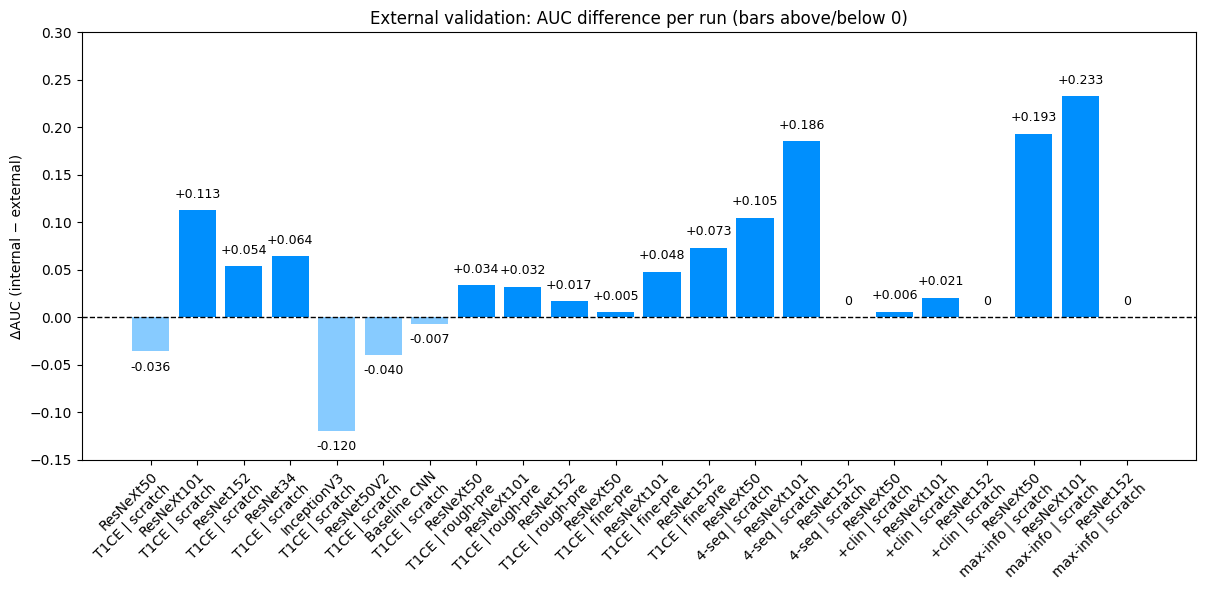

In [29]:
# -----------------------------
# BAR PLOT (ΔAUC) with 0-line
# -----------------------------
x = np.arange(len(wide))
delta = wide["delta_auc"].values

fig_w = max(12, 0.28 * len(wide) + 6)
fig, ax = plt.subplots(figsize=(fig_w, 6))

# Color bars depending on sign
colors = [LIGHT_BLUE if v < 0 else DARK_BLUE for v in delta]
bars = ax.bar(x, delta, color=colors)

# 0 reference line
ax.axhline(0.0, linestyle="--", linewidth=1, color="black")

ax.set_ylabel("ΔAUC (internal − external)")
ax.set_title("External validation: AUC difference per run (bars above/below 0)")

# Rotate x-axis labels by 45 degrees
ax.set_xticks(x)
ax.set_xticklabels(
    wide["x_label"].tolist(),
    rotation=45,
    ha="right",
    rotation_mode="anchor"
)

if Y_LIM is not None:
    ax.set_ylim(Y_LIM)
else:
    lo = np.nanmin(delta)
    hi = np.nanmax(delta)
    pad = 0.05
    ax.set_ylim(lo - pad, hi + pad)

# Optional: show exact delta on bars
if SHOW_DELTA_TEXT_ON_BARS:
    for rect, val in zip(bars, delta):
        if not np.isfinite(val):
            continue

        # Format value: show "0" instead of "+0.000"
        if np.isclose(val, 0.0, atol=1e-6):
            label = "0"
        else:
            label = f"{val:+.{DELTA_TEXT_DECIMALS}f}"

        y = rect.get_height()
        va = "bottom" if y >= 0 else "top"
        offset = 0.01 if y >= 0 else -0.01

        ax.text(
            rect.get_x() + rect.get_width()/2,
            y + offset,
            label,
            ha="center",
            va=va,
            fontsize=9
        )

plt.tight_layout()
plt.show()